In [1]:
import pandas as pd# --- Data Loading and Preprocessing ---

file_path = '/home/abrar/Desktop/Code/Temporal HPC/normalized_data.csv'

# Load data
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv(file_path, parse_dates=time_columns)
df.drop(['eligible_time', 'run_time_z', 'minute'], axis=1, inplace=True)

/tmp/ipykernel_25510/642043935.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=time_columns)


In [22]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple

class FCFSScheduler:
    def __init__(
        self, 
        total_nodes: int = 1000,
        base_power_rate: float = 0.12,  # dollars per kWh
        peak_to_offpeak_ratio: float = 3.0,
        peak_start: int = 6,   # 6 AM
        peak_end: int = 22,    # 10 PM
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.base_power_rate = base_power_rate
        self.peak_to_offpeak_ratio = peak_to_offpeak_ratio
        self.peak_start = peak_start
        self.peak_end = peak_end
        self.running_jobs: List[Dict] = []
        self.completed_jobs: List[Dict] = []
        self.queued_jobs: List[Dict] = []
        self.current_time = None
        self.power_cost = 0.0
        
    def is_peak_hour(self, time: datetime) -> bool:
        """Check if given time is during peak hours."""
        return self.peak_start <= time.hour < self.peak_end
        
    def get_power_rate(self, time: datetime) -> float:
        """Get power rate based on time of day."""
        return (self.base_power_rate * self.peak_to_offpeak_ratio 
                if self.is_peak_hour(time) else self.base_power_rate)
    
    def calculate_job_power_cost(
        self, 
        start_time: datetime, 
        end_time: datetime, 
        power_consumption: float
    ) -> float:
        """Calculate power cost for a job considering peak/off-peak hours."""
        current = start_time
        total_cost = 0.0
        
        while current < end_time:
            next_hour = current.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
            if next_hour > end_time:
                next_hour = end_time
                
            duration = (next_hour - current).total_seconds() / 3600  # in hours
            rate = self.get_power_rate(current)
            
            # Power consumption is in Watts, convert to kW
            total_cost += duration * (power_consumption / 1000) * rate
            current = next_hour
            
        return total_cost
    
    def calculate_metrics(self) -> Dict:
        """Calculate additional scheduling and utilization metrics."""
        metrics = {
            'queue_statistics': {
                'max_queue_length': 0,
                'avg_queue_length': 0,
                'avg_queue_time': 0
            },
            'utilization': {
                'avg_node_utilization': 0,
                'peak_utilization': 0,
                'total_node_hours': 0
            },
            'job_statistics': {
                'total_jobs': len(self.completed_jobs),
                'avg_runtime': 0,
                'avg_nodes_per_job': 0,
                'peak_jobs': 0,
                'offpeak_jobs': 0
            }
        }
        
        # Calculate queue statistics
        queue_lengths = []
        queue_times = []
        for job in self.completed_jobs:
            wait_time = (job['start_time'] - pd.Timestamp(job['submit_time'])).total_seconds()
            queue_times.append(wait_time)
            
        if queue_times:
            metrics['queue_statistics']['avg_queue_time'] = np.mean(queue_times)
            metrics['queue_statistics']['max_queue_length'] = max(queue_lengths) if queue_lengths else 0
            metrics['queue_statistics']['avg_queue_length'] = np.mean(queue_lengths) if queue_lengths else 0
            
        # Calculate utilization metrics
        total_node_seconds = sum(
            job['num_nodes_alloc'] * job['run_time'] 
            for job in self.completed_jobs
        )
        simulation_hours = 24  # one day simulation
        metrics['utilization']['total_node_hours'] = total_node_seconds / 3600
        metrics['utilization']['avg_node_utilization'] = (
            total_node_seconds / (self.total_nodes * simulation_hours * 3600)
        )
        
        # Calculate job statistics
        if self.completed_jobs:
            metrics['job_statistics']['avg_runtime'] = np.mean(
                [job['run_time'] for job in self.completed_jobs]
            )
            metrics['job_statistics']['avg_nodes_per_job'] = np.mean(
                [job['num_nodes_alloc'] for job in self.completed_jobs]
            )
            metrics['job_statistics']['peak_jobs'] = sum(
                1 for job in self.completed_jobs 
                if self.is_peak_hour(pd.Timestamp(job['start_time']))
            )
            metrics['job_statistics']['offpeak_jobs'] = len(self.completed_jobs) - metrics['job_statistics']['peak_jobs']
            
        return metrics
    
    def simulate_day(
        self, 
        df: pd.DataFrame, 
        start_date: datetime
    ) -> Tuple[float, pd.DataFrame]:
        """Simulate one day of job scheduling."""
        end_date = start_date + timedelta(days=1)
        
        # Filter jobs for the simulation day
        day_jobs = df[
            (df['submit_time'] >= start_date) & 
            (df['submit_time'] < end_date)
        ].sort_values('submit_time').copy()
        
        if len(day_jobs) == 0:
            print(f"No jobs found for date {start_date.date()}")
            return 0.0, pd.DataFrame()
        
        metrics = []
        self.current_time = start_date
        self.available_nodes = self.total_nodes
        self.power_cost = 0.0
        
        while self.current_time < end_date:
            # Process completed jobs
            completed = []
            for job in self.running_jobs:
                if job['end_time'] <= self.current_time:
                    completed.append(job)
                    self.available_nodes += job['num_nodes_alloc']
                    
                    power_cost = self.calculate_job_power_cost(
                        job['start_time'],
                        job['end_time'],
                        job['mean_node_power'] * job['num_nodes_alloc']
                    )
                    self.power_cost += power_cost
                    
                    metrics.append({
                        'job_id': job['job_id'],
                        'start_time': job['start_time'],
                        'end_time': job['end_time'],
                        'num_nodes': job['num_nodes_alloc'],
                        'power_consumption': job['mean_node_power'],
                        'power_cost': power_cost,
                        'is_peak': self.is_peak_hour(job['start_time'])
                    })
                    
            for job in completed:
                self.running_jobs.remove(job)
                self.completed_jobs.append(job)
            
            # Process new jobs
            available_jobs = day_jobs[
                (day_jobs['submit_time'] <= self.current_time) & 
                (~day_jobs['job_id'].isin([j['job_id'] for j in self.running_jobs + self.completed_jobs]))
            ]
            
            for _, job in available_jobs.iterrows():
                if job['num_nodes_alloc'] <= self.available_nodes:
                    self.available_nodes -= job['num_nodes_alloc']
                    
                    job_dict = job.to_dict()
                    job_dict['start_time'] = self.current_time
                    job_dict['end_time'] = self.current_time + pd.Timedelta(seconds=job['run_time'])
                    self.running_jobs.append(job_dict)
                else:
                    self.queued_jobs.append(job.to_dict())
            
            # Advance time to next event
            next_times = []
            if len(self.running_jobs) > 0:
                next_times.append(min(job['end_time'] for job in self.running_jobs))
            if len(available_jobs) < len(day_jobs):
                next_submit = day_jobs[
                    ~day_jobs['job_id'].isin([j['job_id'] for j in self.running_jobs + self.completed_jobs])
                ]['submit_time'].min()
                if pd.notna(next_submit):
                    next_times.append(next_submit)
            
            if len(next_times) > 0:
                self.current_time = min(next_times)
            else:
                self.current_time = end_date
                
        return self.power_cost, pd.DataFrame(metrics)

def run_simulation(df: pd.DataFrame, simulation_date: datetime) -> Tuple[pd.DataFrame, Dict]:
    """Run the FCFS simulation for a specific date."""
    scheduler = FCFSScheduler()
    total_cost, metrics_df = scheduler.simulate_day(df, simulation_date)
    
    # Print summary statistics
    print(f"\nSimulation Results for {simulation_date.date()}")
    print("-" * 50)
    print(f"Total Power Cost: ${total_cost:.2f}")
    
    if len(metrics_df) > 0:
        print(f"Total Jobs Completed: {len(metrics_df)}")
        print(f"Average Power Cost per Job: ${total_cost/len(metrics_df):.2f}")
        
        # Calculate peak vs off-peak costs
        peak_costs = metrics_df[metrics_df['is_peak']]['power_cost'].sum()
        off_peak_costs = metrics_df[~metrics_df['is_peak']]['power_cost'].sum()
        print(f"Peak Hours Cost: ${peak_costs:.2f}")
        print(f"Off-Peak Hours Cost: ${off_peak_costs:.2f}")
        
        # Calculate and print additional metrics
        additional_metrics = scheduler.calculate_metrics()
        print("\nQueue Statistics:")
        print(f"  Average Queue Time: {additional_metrics['queue_statistics']['avg_queue_time']/60:.2f} minutes")
        print(f"  Maximum Queue Length: {additional_metrics['queue_statistics']['max_queue_length']}")
        print(f"  Average Queue Length: {additional_metrics['queue_statistics']['avg_queue_length']:.2f}")
        
        print("\nUtilization Statistics:")
        print(f"  Average Node Utilization: {additional_metrics['utilization']['avg_node_utilization']*100:.2f}%")
        print(f"  Total Node Hours: {additional_metrics['utilization']['total_node_hours']:.2f}")
        
        print("\nJob Statistics:")
        print(f"  Total Jobs Completed: {additional_metrics['job_statistics']['total_jobs']}")
        print(f"  Average Runtime: {additional_metrics['job_statistics']['avg_runtime']/60:.2f} minutes")
        print(f"  Average Nodes per Job: {additional_metrics['job_statistics']['avg_nodes_per_job']:.2f}")
        print(f"  Peak Hours Jobs: {additional_metrics['job_statistics']['peak_jobs']}")
        print(f"  Off-Peak Hours Jobs: {additional_metrics['job_statistics']['offpeak_jobs']}")
        
        return metrics_df, additional_metrics
    else:
        print("No jobs were completed during the simulation period")
        return pd.DataFrame(), {}

# Example usage
if __name__ == "__main__":
    # Read the dataset
    df = pd.read_csv('/home/abrar/Desktop/Code/Temporal HPC/normalized_data.csv', parse_dates=['submit_time', 'start_time', 'end_time'])
    
    # Set simulation date
    simulation_date = datetime(2020, 8, 15)
    
    # Run simulation
    metrics_df, additional_metrics = run_simulation(df, simulation_date)


Simulation Results for 2020-08-15
--------------------------------------------------
Total Power Cost: $189.34
Total Jobs Completed: 147
Average Power Cost per Job: $1.29
Peak Hours Cost: $180.07
Off-Peak Hours Cost: $9.27

Queue Statistics:
  Average Queue Time: 0.00 minutes
  Maximum Queue Length: 0
  Average Queue Length: 0.00

Utilization Statistics:
  Average Node Utilization: 2.29%
  Total Node Hours: 548.66

Job Statistics:
  Total Jobs Completed: 147
  Average Runtime: 115.97 minutes
  Average Nodes per Job: 1.58
  Peak Hours Jobs: 127
  Off-Peak Hours Jobs: 20


In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from dataclasses import dataclass
from queue import PriorityQueue

@dataclass
class Job:
    job_id: int
    submit_time: datetime
    run_time: float
    num_nodes_alloc: int
    mean_node_power: float
    cores_per_task: int
    shared: int
    priority: int
    
    @property
    def power_efficiency(self) -> float:
        """Calculate power efficiency (lower is better)"""
        return self.mean_node_power * self.num_nodes_alloc / self.run_time
    
    def __lt__(self, other):
        """Compare jobs based on power efficiency for priority queue"""
        return self.power_efficiency < other.power_efficiency

class PowerAwareScheduler:
    def __init__(
        self, 
        total_nodes: int = 1000,
        base_power_rate: float = 0.12,
        peak_to_offpeak_ratio: float = 3.0,
        peak_start: int = 6,
        peak_end: int = 22,
        peak_power_budget: float = None  # In kW, None means no budget
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.base_power_rate = base_power_rate
        self.peak_to_offpeak_ratio = peak_to_offpeak_ratio
        self.peak_start = peak_start
        self.peak_end = peak_end
        self.peak_power_budget = peak_power_budget
        
        self.running_jobs: List[Dict] = []
        self.completed_jobs: List[Dict] = []
        self.high_power_queue = PriorityQueue()  # For jobs exceeding power budget
        self.low_power_queue = PriorityQueue()   # For jobs within power budget
        self.current_time = None
        self.power_cost = 0.0
        
    def is_peak_hour(self, time: datetime) -> bool:
        return self.peak_start <= time.hour < self.peak_end
        
    def get_power_rate(self, time: datetime) -> float:
        return (self.base_power_rate * self.peak_to_offpeak_ratio 
                if self.is_peak_hour(time) else self.base_power_rate)
    
    def get_current_power_usage(self) -> float:
        """Calculate current total power usage in kW"""
        return sum(
            job['mean_node_power'] * job['num_nodes_alloc'] / 1000  # Convert W to kW
            for job in self.running_jobs
        )
    
    def can_schedule_job(self, job: Dict) -> bool:
        """Check if job can be scheduled considering power budget and time constraints"""
        # First check node availability
        if job['num_nodes_alloc'] > self.available_nodes:
            return False
            
        current_power = self.get_current_power_usage()
        job_power = job['mean_node_power'] * job['num_nodes_alloc'] / 1000
        projected_power = current_power + job_power
        
        # During peak hours
        if self.is_peak_hour(self.current_time):
            if self.peak_power_budget is None:
                return True
            return projected_power <= self.peak_power_budget
        
        # During off-peak hours, prioritize high-power jobs
        else:
            # Allow all jobs during off-peak, but prioritize high-power ones
            return True
    
    def sort_jobs_by_power(self, jobs: pd.DataFrame) -> Tuple[List[Job], List[Job]]:
        """Sort jobs into high and low power consumption queues based on median power consumption"""
        high_power_jobs = []
        low_power_jobs = []
        
        # Calculate median power consumption per job
        power_consumptions = jobs['mean_node_power'] * jobs['num_nodes_alloc']
        median_power = power_consumptions.median()
        
        for _, job_data in jobs.iterrows():
            job = Job(
                job_id=job_data['job_id'],
                submit_time=job_data['submit_time'],
                run_time=job_data['run_time'],
                num_nodes_alloc=job_data['num_nodes_alloc'],
                mean_node_power=job_data['mean_node_power'],
                cores_per_task=job_data['cores_per_task'],
                shared=job_data['shared'],
                priority=job_data['priority']
            )
            
            # Jobs with above-median power consumption go to high_power_queue
            if (job.mean_node_power * job.num_nodes_alloc) > median_power:
                high_power_jobs.append(job)
            else:
                low_power_jobs.append(job)
                
        return high_power_jobs, low_power_jobs
    
    def calculate_job_power_cost(
        self, 
        start_time: datetime, 
        end_time: datetime, 
        power_consumption: float
    ) -> float:
        """Calculate power cost for a job considering peak/off-peak hours"""
        current = start_time
        total_cost = 0.0
        
        while current < end_time:
            next_hour = current.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
            if next_hour > end_time:
                next_hour = end_time
                
            duration = (next_hour - current).total_seconds() / 3600
            rate = self.get_power_rate(current)
            
            # Power consumption is in Watts, convert to kW
            total_cost += duration * (power_consumption / 1000) * rate
            current = next_hour
            
        return total_cost
    
    def simulate_day(
        self, 
        df: pd.DataFrame, 
        start_date: datetime
    ) -> Tuple[float, pd.DataFrame, Dict]:
        """Simulate one day of power-aware job scheduling"""
        end_date = start_date + timedelta(days=1)
        
        # Filter jobs for the simulation day
        day_jobs = df[
            (df['submit_time'] >= start_date) & 
            (df['submit_time'] < end_date)
        ].sort_values('submit_time').copy()
        
        if len(day_jobs) == 0:
            return 0.0, pd.DataFrame(), {}
            
        metrics = []
        self.current_time = start_date
        self.available_nodes = self.total_nodes
        self.power_cost = 0.0
        
        # Initial sort of jobs by power consumption
        high_power_jobs, low_power_jobs = self.sort_jobs_by_power(day_jobs)
        
        for job in high_power_jobs:
            self.high_power_queue.put(job)
        for job in low_power_jobs:
            self.low_power_queue.put(job)
            
        while self.current_time < end_date:
            # Process completed jobs
            completed = []
            for job in self.running_jobs:
                if job['end_time'] <= self.current_time:
                    completed.append(job)
                    self.available_nodes += job['num_nodes_alloc']
                    
                    power_cost = self.calculate_job_power_cost(
                        job['start_time'],
                        job['end_time'],
                        job['mean_node_power'] * job['num_nodes_alloc']
                    )
                    self.power_cost += power_cost
                    
                    metrics.append({
                        'job_id': job['job_id'],
                        'start_time': job['start_time'],
                        'end_time': job['end_time'],
                        'num_nodes': job['num_nodes_alloc'],
                        'power_consumption': job['mean_node_power'],
                        'power_cost': power_cost,
                        'is_peak': self.is_peak_hour(job['start_time'])
                    })
                    
            for job in completed:
                self.running_jobs.remove(job)
                self.completed_jobs.append(job)
            
            # Try to schedule jobs based on current time period
            is_peak = self.is_peak_hour(self.current_time)
            
            # During peak hours, try low power jobs first
            if is_peak:
                queues_to_try = [self.low_power_queue, self.high_power_queue]
            # During off-peak hours, try high power jobs first
            else:
                queues_to_try = [self.high_power_queue, self.low_power_queue]
            
            for current_queue in queues_to_try:
                while not current_queue.empty():
                    job = current_queue.get()
                    if job.submit_time <= self.current_time:
                        job_dict = day_jobs[day_jobs['job_id'] == job.job_id].iloc[0].to_dict()
                        
                        if self.can_schedule_job(job_dict):
                            self.available_nodes -= job_dict['num_nodes_alloc']
                            job_dict['start_time'] = self.current_time
                            job_dict['end_time'] = self.current_time + pd.Timedelta(seconds=job_dict['run_time'])
                            self.running_jobs.append(job_dict)
                        else:
                            # Put back in queue if can't schedule now
                            current_queue.put(job)
                            if is_peak and self.get_current_power_usage() > self.peak_power_budget:
                                break
                    else:
                        # Put back in queue if not ready
                        current_queue.put(job)
                        break
            
            # Advance time to next event
            next_times = []
            if self.running_jobs:
                next_times.append(min(job['end_time'] for job in self.running_jobs))
            
            # Add next hour boundary for peak/off-peak transitions
            next_hour = self.current_time.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
            next_times.append(next_hour)
            
            if next_times:
                self.current_time = min(next_times)
            else:
                self.current_time = end_date
                
        return self.power_cost, pd.DataFrame(metrics), self.calculate_metrics()
    
    def calculate_metrics(self) -> Dict:
        """Calculate scheduling and power usage metrics"""
        metrics = {
            'power_metrics': {
                'peak_power_usage': [],
                'offpeak_power_usage': [],
                'power_budget_violations': 0,
                'avg_peak_power': 0,
                'avg_offpeak_power': 0
            },
            'job_statistics': {
                'total_jobs': len(self.completed_jobs),
                'peak_jobs': 0,
                'offpeak_jobs': 0,
                'avg_wait_time': 0
            }
        }
        
        # Calculate power usage statistics
        for job in self.completed_jobs:
            power_usage = job['mean_node_power'] * job['num_nodes_alloc'] / 1000  # kW
            if self.is_peak_hour(job['start_time']):
                metrics['power_metrics']['peak_power_usage'].append(power_usage)
                metrics['job_statistics']['peak_jobs'] += 1
            else:
                metrics['power_metrics']['offpeak_power_usage'].append(power_usage)
                metrics['job_statistics']['offpeak_jobs'] += 1
        
        if metrics['power_metrics']['peak_power_usage']:
            metrics['power_metrics']['avg_peak_power'] = np.mean(
                metrics['power_metrics']['peak_power_usage']
            )
        if metrics['power_metrics']['offpeak_power_usage']:
            metrics['power_metrics']['avg_offpeak_power'] = np.mean(
                metrics['power_metrics']['offpeak_power_usage']
            )
            
        return metrics

def run_simulation(
    df: pd.DataFrame, 
    simulation_date: datetime,
    peak_power_budget: float = None
) -> Tuple[pd.DataFrame, Dict]:
    """Run power-aware simulation for a specific date"""
    scheduler = PowerAwareScheduler(peak_power_budget=peak_power_budget)
    total_cost, metrics_df, additional_metrics = scheduler.simulate_day(df, simulation_date)
    
    print(f"\nSimulation Results for {simulation_date.date()}")
    print("-" * 50)
    print(f"Total Power Cost: ${total_cost:.2f}")
    
    if len(metrics_df) > 0:
        print(f"Total Jobs Completed: {len(metrics_df)}")
        print(f"Average Power Cost per Job: ${total_cost/len(metrics_df):.2f}")
        
        peak_metrics = metrics_df[metrics_df['is_peak']]
        offpeak_metrics = metrics_df[~metrics_df['is_peak']]
        
        print(f"\nPeak Hours Statistics:")
        print(f"  Jobs: {len(peak_metrics)}")
        print(f"  Total Cost: ${peak_metrics['power_cost'].sum():.2f}")
        print(f"  Average Power Usage: {additional_metrics['power_metrics']['avg_peak_power']:.2f} kW")
        
        print(f"\nOff-Peak Hours Statistics:")
        print(f"  Jobs: {len(offpeak_metrics)}")
        print(f"  Total Cost: ${offpeak_metrics['power_cost'].sum():.2f}")
        print(f"  Average Power Usage: {additional_metrics['power_metrics']['avg_offpeak_power']:.2f} kW")
        
        if peak_power_budget:
            print(f"\nPower Budget: {peak_power_budget} kW")
            
        return metrics_df, additional_metrics
    else:
        print("No jobs were completed during the simulation period")
        return pd.DataFrame(), {}

In [27]:
# Read your dataset
df = pd.read_csv('/home/abrar/Desktop/Code/Temporal HPC/normalized_data.csv', parse_dates=['submit_time', 'start_time', 'end_time'])

# Set simulation date
simulation_date = datetime(2020, 9, 15)

# Test with different power budgets (in kW)
budgets_to_test = [
    None,    # Baseline
    1000,    # Very permissive
    500,     # Moderate
    250      # Restrictive
]

for budget in budgets_to_test:
    print(f"\n{'='*80}")
    print(f"Testing with {'no' if budget is None else str(budget)} kW budget:")
    metrics_df, additional_metrics = run_simulation(df, simulation_date, peak_power_budget=budget)


Testing with no kW budget:

Simulation Results for 2020-09-15
--------------------------------------------------
Total Power Cost: $60.30
Total Jobs Completed: 410
Average Power Cost per Job: $0.15

Peak Hours Statistics:
  Jobs: 106
  Total Cost: $46.71
  Average Power Usage: 0.78 kW

Off-Peak Hours Statistics:
  Jobs: 304
  Total Cost: $13.59
  Average Power Usage: 0.60 kW

Testing with 1000 kW budget:

Simulation Results for 2020-09-15
--------------------------------------------------
Total Power Cost: $60.30
Total Jobs Completed: 410
Average Power Cost per Job: $0.15

Peak Hours Statistics:
  Jobs: 106
  Total Cost: $46.71
  Average Power Usage: 0.78 kW

Off-Peak Hours Statistics:
  Jobs: 304
  Total Cost: $13.59
  Average Power Usage: 0.60 kW

Power Budget: 1000 kW

Testing with 500 kW budget:

Simulation Results for 2020-09-15
--------------------------------------------------
Total Power Cost: $60.30
Total Jobs Completed: 410
Average Power Cost per Job: $0.15

Peak Hours Stati

Simulation Results for 2020-08-15
--------------------------------------------------
Total Power Cost: $189.34
Total Jobs Completed: 147
Average Power Cost per Job: $1.29
Peak Hours Cost: $180.07
Off-Peak Hours Cost: $9.27

Queue Statistics:
  Average Queue Time: 0.00 minutes
  Maximum Queue Length: 0
  Average Queue Length: 0.00

Utilization Statistics:
  Average Node Utilization: 2.29%
  Total Node Hours: 548.66

Job Statistics:
  Total Jobs Completed: 147
  Average Runtime: 115.97 minutes
  Average Nodes per Job: 1.58
  Peak Hours Jobs: 127
  Off-Peak Hours Jobs: 20

# Testing with synthetic dataset

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_synthetic_jobs(
    start_date: datetime,
    num_days: int = 1,
    num_jobs_per_day: int = 100,
    seed: int = 42
) -> pd.DataFrame:
    """
    Generate synthetic HPC job data with varied power consumption patterns.
    
    Args:
        start_date: Starting date for job submissions
        num_days: Number of days to generate data for
        num_jobs_per_day: Average number of jobs per day
        seed: Random seed for reproducibility
    
    Returns:
        DataFrame containing synthetic job data
    """
    np.random.seed(seed)
    
    # Define job types with different power characteristics
    job_types = {
        'small_fast': {
            'nodes': (1, 4),
            'runtime': (300, 1800),  # 5-30 minutes
            'power': (100, 200),     # Watts per node
            'weight': 0.4            # 40% of jobs
        },
        'medium': {
            'nodes': (4, 16),
            'runtime': (1800, 7200),  # 30-120 minutes
            'power': (200, 400),      # Watts per node
            'weight': 0.3             # 30% of jobs
        },
        'large_long': {
            'nodes': (16, 64),
            'runtime': (7200, 14400), # 2-4 hours
            'power': (400, 800),      # Watts per node
            'weight': 0.2             # 20% of jobs
        },
        'high_power': {
            'nodes': (32, 128),
            'runtime': (3600, 10800), # 1-3 hours
            'power': (800, 1200),     # Watts per node
            'weight': 0.1             # 10% of jobs
        }
    }
    
    jobs = []
    job_id = 1
    
    for day in range(num_days):
        current_date = start_date + timedelta(days=day)
        
        # Generate variable number of jobs for the day
        daily_jobs = np.random.poisson(num_jobs_per_day)
        
        # Distribute jobs throughout the day
        submit_times = np.sort(np.random.uniform(
            0, 
            24*3600, 
            daily_jobs
        ))
        
        for submit_time in submit_times:
            # Select job type based on weights
            job_type = np.random.choice(
                list(job_types.keys()),
                p=[t['weight'] for t in job_types.values()]
            )
            params = job_types[job_type]
            
            # Generate job parameters
            num_nodes = np.random.randint(*params['nodes'])
            runtime = np.random.uniform(*params['runtime'])
            power_per_node = np.random.uniform(*params['power'])
            
            # Calculate submit time
            submit_datetime = current_date + timedelta(seconds=float(submit_time))
            
            # Add some randomness to cores per task
            cores_per_task = np.random.choice([1, 2, 4, 8, 16])
            
            jobs.append({
                'job_id': job_id,
                'submit_time': submit_datetime,
                'num_nodes_alloc': num_nodes,
                'run_time': runtime,
                'mean_cpu_power': power_per_node * 0.7,  # CPU is 70% of node power
                'mean_mem_power': power_per_node * 0.3,  # Memory is 30% of node power
                'mean_node_power': power_per_node,
                'cores_per_task': cores_per_task,
                'shared': np.random.choice([0, 1], p=[0.7, 0.3]),  # 30% chance of shared
                'priority': np.random.randint(1, 5),
                'job_type': job_type
            })
            job_id += 1
    
    # Convert to DataFrame
    df = pd.DataFrame(jobs)
    
    # Sort by submit time
    df = df.sort_values('submit_time')
    
    # Add state_reason field (mostly "None" with some timeouts)
    df['state_reason'] = np.random.choice(
        ['None', 'TimeLimit'], 
        size=len(df), 
        p=[0.95, 0.05]
    )
    
    return df

def print_dataset_stats(df: pd.DataFrame) -> None:
    """Print statistics about the generated dataset."""
    print("\nDataset Statistics:")
    print("-" * 50)
    
    print("\nJob Type Distribution:")
    print(df['job_type'].value_counts(normalize=True).round(3) * 100)
    
    print("\nPower Usage Statistics (Watts per node):")
    print(df['mean_node_power'].describe().round(2))
    
    print("\nNode Allocation Statistics:")
    print(df['num_nodes_alloc'].describe().round(2))
    
    print("\nRuntime Statistics (hours):")
    print((df['run_time'] / 3600).describe().round(2))
    
    # Calculate total power if all jobs ran simultaneously
    total_power = (df['mean_node_power'] * df['num_nodes_alloc']).sum() / 1000
    print(f"\nTotal power if all jobs ran simultaneously: {total_power:.2f} kW")

if __name__ == "__main__":
    # Generate sample dataset
    start_date = datetime(2024, 2, 11)  # Use current date
    df = generate_synthetic_jobs(start_date)
    
    # Print statistics
    print_dataset_stats(df)
    
    # Save to CSV
    df.to_csv('synthetic_hpc_jobs.csv', index=False)
    print("\nDataset saved to 'synthetic_hpc_jobs.csv'")


Dataset Statistics:
--------------------------------------------------

Job Type Distribution:
job_type
small_fast    42.7
medium        31.2
large_long    15.6
high_power    10.4
Name: proportion, dtype: float64

Power Usage Statistics (Watts per node):
count      96.00
mean      351.36
std       273.07
min       100.05
25%       154.32
50%       237.55
75%       421.96
max      1174.69
Name: mean_node_power, dtype: float64

Node Allocation Statistics:
count     96.00
mean      17.41
std       23.58
min        1.00
25%        2.00
50%        6.50
75%       25.00
max      105.00
Name: num_nodes_alloc, dtype: float64

Runtime Statistics (hours):
count    96.00
mean      1.21
std       1.04
min       0.10
25%       0.36
50%       0.88
75%       1.79
max       3.93
Name: run_time, dtype: float64

Total power if all jobs ran simultaneously: 1133.14 kW

Dataset saved to 'synthetic_hpc_jobs.csv'


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from queue import PriorityQueue

class PowerAwareJob:
    """Class to represent a job with power-aware sorting capabilities"""
    def __init__(self, job_data: pd.Series):
        self.job_id = job_data['job_id']
        self.submit_time = job_data['submit_time']
        self.run_time = job_data['run_time']
        self.num_nodes = job_data['num_nodes_alloc']
        self.node_power = job_data['mean_node_power']
        self.total_power = self.node_power * self.num_nodes
        self.power_density = self.total_power / self.run_time
        self.data = job_data
        
    def __lt__(self, other):
        # Sort by power density (lower is preferred during peak hours)
        return self.power_density < other.power_density

class PowerAwareScheduler:
    def __init__(
        self,
        total_nodes: int = 1000,
        peak_power_budget: float = None,  # in kW
        peak_hours: tuple = (6, 22),      # 6 AM to 10 PM
        power_rates: tuple = (0.12, 0.36) # off-peak and peak rates in $/kWh
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.peak_power_budget = peak_power_budget
        self.peak_start, self.peak_end = peak_hours
        self.off_peak_rate, self.peak_rate = power_rates
        
        # Queues for different job types
        self.peak_queue = PriorityQueue()    # Low power density jobs
        self.offpeak_queue = PriorityQueue() # High power density jobs
        
        # Tracking
        self.running_jobs: List[Dict] = []
        self.completed_jobs: List[Dict] = []
        self.power_usage_log = []
        self.current_time = None
        
    def is_peak_hour(self, time: datetime) -> bool:
        """Check if given time is during peak hours"""
        return self.peak_start <= time.hour < self.peak_end
    
    def get_power_rate(self, time: datetime) -> float:
        """Get power rate based on time"""
        return self.peak_rate if self.is_peak_hour(time) else self.off_peak_rate
    
    def calculate_current_power(self) -> float:
        """Calculate current total power usage in kW"""
        if not self.running_jobs:
            return 0.0
        return sum(job['mean_node_power'] * job['num_nodes_alloc'] 
                  for job in self.running_jobs) / 1000
    
    def can_schedule_job(self, job: PowerAwareJob) -> bool:
        """Check if job can be scheduled considering power and node constraints"""
        # Check node availability
        if job.num_nodes > self.available_nodes:
            return False
            
        # If not peak hour or no budget, only check nodes
        if not self.is_peak_hour(self.current_time) or self.peak_power_budget is None:
            return True
            
        # Check power budget during peak hours
        current_power = self.calculate_current_power()
        job_power = job.total_power / 1000  # Convert to kW
        return (current_power + job_power) <= self.peak_power_budget
    
    def sort_jobs(self, jobs_df: pd.DataFrame) -> None:
        """Sort jobs into appropriate queues based on power density"""
        # Calculate median power density
        power_densities = []
        for _, job_data in jobs_df.iterrows():
            power = job_data['mean_node_power'] * job_data['num_nodes_alloc']
            density = power / job_data['run_time']
            power_densities.append(density)
        
        median_density = np.median(power_densities)
        
        # Sort jobs into queues
        for _, job_data in jobs_df.iterrows():
            job = PowerAwareJob(job_data)
            if job.power_density > median_density:
                self.offpeak_queue.put(job)  # High power density -> off-peak
            else:
                self.peak_queue.put(job)     # Low power density -> peak
    
    def simulate(self, jobs_df: pd.DataFrame, start_time: datetime) -> Tuple[pd.DataFrame, Dict]:
        """Run power-aware scheduling simulation"""
        self.current_time = start_time
        end_time = start_time + timedelta(days=1)
        
        # Initialize queues
        self.sort_jobs(jobs_df)
        
        metrics = []
        
        while self.current_time < end_time:
            # Log current state
            self.power_usage_log.append({
                'time': self.current_time,
                'power_usage': self.calculate_current_power(),
                'is_peak': self.is_peak_hour(self.current_time),
                'running_jobs': len(self.running_jobs)
            })
            
            # Complete finished jobs
            completed = []
            for job in self.running_jobs:
                if job['end_time'] <= self.current_time:
                    completed.append(job)
                    self.available_nodes += job['num_nodes_alloc']
                    
                    # Calculate power cost
                    power_kw = job['mean_node_power'] * job['num_nodes_alloc'] / 1000
                    runtime_hours = job['run_time'] / 3600
                    rate = self.get_power_rate(job['start_time'])
                    cost = power_kw * runtime_hours * rate
                    
                    metrics.append({
                        'job_id': job['job_id'],
                        'start_time': job['start_time'],
                        'end_time': job['end_time'],
                        'run_time': job['run_time'],
                        'num_nodes': job['num_nodes_alloc'],
                        'power_kw': power_kw,
                        'cost': cost,
                        'is_peak': self.is_peak_hour(job['start_time'])
                    })
            
            for job in completed:
                self.running_jobs.remove(job)
                self.completed_jobs.append(job)
            
            # Schedule new jobs
            is_peak = self.is_peak_hour(self.current_time)
            primary_queue = self.peak_queue if is_peak else self.offpeak_queue
            secondary_queue = self.offpeak_queue if is_peak else self.peak_queue
            
            # Try scheduling from primary queue
            while not primary_queue.empty():
                job = primary_queue.get()
                if job.submit_time <= self.current_time:
                    if self.can_schedule_job(job):
                        self._schedule_job(job)
                    else:
                        primary_queue.put(job)
                        break
                else:
                    primary_queue.put(job)
                    break
            
            # Try secondary queue if power budget allows
            if not is_peak or (self.peak_power_budget and 
                             self.calculate_current_power() < self.peak_power_budget * 0.8):
                while not secondary_queue.empty():
                    job = secondary_queue.get()
                    if job.submit_time <= self.current_time:
                        if self.can_schedule_job(job):
                            self._schedule_job(job)
                        else:
                            secondary_queue.put(job)
                            break
                    else:
                        secondary_queue.put(job)
                        break
            
            # Advance time
            next_times = []
            
            # Add job completion times
            if self.running_jobs:
                next_times.append(min(job['end_time'] for job in self.running_jobs))
            
            # Add next hour boundary
            next_hour = self.current_time.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
            if next_hour > self.current_time:
                next_times.append(next_hour)
                
            # Add next job submit time
            if not primary_queue.empty():
                next_times.append(primary_queue.queue[0].submit_time)
            if not secondary_queue.empty():
                next_times.append(secondary_queue.queue[0].submit_time)
            
            self.current_time = min(next_times) if next_times else end_time
        
        return pd.DataFrame(metrics), self._calculate_summary_metrics()
    
    def _schedule_job(self, job: PowerAwareJob) -> None:
        """Schedule a job to run"""
        self.available_nodes -= job.num_nodes
        
        job_dict = job.data.to_dict()
        job_dict['start_time'] = self.current_time
        job_dict['end_time'] = self.current_time + timedelta(seconds=job.run_time)
        
        self.running_jobs.append(job_dict)
    
    def _calculate_summary_metrics(self) -> Dict:
        """Calculate summary metrics for the simulation"""
        metrics = {
            'total_jobs_completed': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs 
                           if self.is_peak_hour(job['start_time'])),
            'offpeak_jobs': sum(1 for job in self.completed_jobs 
                              if not self.is_peak_hour(job['start_time'])),
            'power_metrics': {
                'max_power': max(log['power_usage'] for log in self.power_usage_log),
                'avg_peak_power': np.mean([log['power_usage'] for log in self.power_usage_log 
                                         if log['is_peak']]),
                'avg_offpeak_power': np.mean([log['power_usage'] for log in self.power_usage_log 
                                            if not log['is_peak']])
            }
        }
        return metrics

def run_simulation(df: pd.DataFrame, power_budget: float = None) -> None:
    """Run simulation with given power budget and print results"""
    scheduler = PowerAwareScheduler(peak_power_budget=power_budget)
    start_time = df['submit_time'].min()
    
    metrics_df, summary_metrics = scheduler.simulate(df, start_time)
    
    print("\nSimulation Results")
    print("-" * 50)
    print(f"Power Budget: {'None' if power_budget is None else f'{power_budget} kW'}")
    print(f"\nTotal Jobs Completed: {summary_metrics['total_jobs_completed']}")
    print(f"Peak Hours Jobs: {summary_metrics['peak_jobs']}")
    print(f"Off-Peak Hours Jobs: {summary_metrics['offpeak_jobs']}")
    
    print(f"\nPower Usage:")
    print(f"Maximum Power: {summary_metrics['power_metrics']['max_power']:.2f} kW")
    print(f"Average Peak Power: {summary_metrics['power_metrics']['avg_peak_power']:.2f} kW")
    print(f"Average Off-Peak Power: {summary_metrics['power_metrics']['avg_offpeak_power']:.2f} kW")
    
    total_cost = metrics_df['cost'].sum()
    peak_cost = metrics_df[metrics_df['is_peak']]['cost'].sum()
    offpeak_cost = metrics_df[~metrics_df['is_peak']]['cost'].sum()
    
    print(f"\nPower Costs:")
    print(f"Total Cost: ${total_cost:.2f}")
    print(f"Peak Hours Cost: ${peak_cost:.2f}")
    print(f"Off-Peak Hours Cost: ${offpeak_cost:.2f}")
    
    return metrics_df, summary_metrics

# Test different power budgets
if __name__ == "__main__":
    budgets = [None]  # in kW , 500, 300, 150
    
    for budget in budgets:
        metrics_df, summary = run_simulation(df, budget)
        print("\n" + "="*80 + "\n")

KeyboardInterrupt: 

# Power aware scheduler FCFS

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from heapq import heappush, heappop

class PowerAwareScheduler:
    def __init__(
        self,
        total_nodes: int = 1000,
        peak_power_budget: float = None,  # in kW
        peak_start: int = 6,
        peak_end: int = 22,
        base_rate: float = 0.12,     # $/kWh
        peak_rate_multiplier: float = 3
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.peak_power_budget = peak_power_budget
        self.peak_start = peak_start
        self.peak_end = peak_end
        self.base_rate = base_rate
        self.peak_rate = base_rate * peak_rate_multiplier
        
        # Event queue for efficient time advancement
        self.event_queue = []
        self.running_jobs = {}  # job_id -> job_dict
        self.current_time = None
        
        # Metrics tracking
        self.total_cost = 0
        self.peak_cost = 0
        self.offpeak_cost = 0
        self.completed_jobs = []
        self.power_log = []

    def is_peak_hour(self, time: datetime) -> bool:
        return self.peak_start <= time.hour < self.peak_end

    def get_power_rate(self, time: datetime) -> float:
        return self.peak_rate if self.is_peak_hour(time) else self.base_rate

    def calculate_current_power(self) -> float:
        if not self.running_jobs:
            return 0.0
        return sum(job['power_kw'] for job in self.running_jobs.values())

    def can_schedule_job(self, job: Dict) -> bool:
        """Check if job can be scheduled considering nodes and power budget"""
        # First check node availability
        if job['num_nodes_alloc'] > self.available_nodes:
            return False
            
        # During peak hours, enforce power budget
        if self.is_peak_hour(self.current_time) and self.peak_power_budget:
            current_power = self.calculate_current_power()
            return (current_power + job['power_kw']) <= self.peak_power_budget
            
        # During off-peak, only check node availability
        return True

    def simulate(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Run power-aware scheduling simulation"""
        # Preprocess jobs
        jobs = df.copy()
        jobs['power_kw'] = jobs['mean_node_power'] * jobs['num_nodes_alloc'] / 1000
        
        # Sort jobs by power consumption for better scheduling decisions
        jobs = jobs.sort_values('power_kw', ascending=False)
        
        # Initialize simulation
        self.current_time = jobs['submit_time'].min()
        end_time = self.current_time + timedelta(days=1)
        
        # Add initial job submissions to event queue
        for _, job in jobs.iterrows():
            heappush(self.event_queue, (job['submit_time'], 'submit', job.to_dict()))
        
        # Track power usage over time
        self.power_usage = []
        
        # Main simulation loop
        while self.event_queue and self.current_time < end_time:
            event_time, event_type, job = heappop(self.event_queue)
            self.current_time = event_time
            
            # Log power usage
            current_power = self.calculate_current_power()
            self.power_usage.append({
                'time': self.current_time,
                'power_usage': current_power,
                'is_peak': self.is_peak_hour(self.current_time),
                'num_running': len(self.running_jobs)
            })
            
            if event_type == 'submit':
                self._handle_submission(job)
            elif event_type == 'complete':
                self._handle_completion(job)
        
        # Calculate final metrics
        peak_power_usage = [log['power_usage'] for log in self.power_usage if log['is_peak']]
        offpeak_power_usage = [log['power_usage'] for log in self.power_usage if not log['is_peak']]
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_usage) if self.power_usage else 0,
            'avg_power': np.mean([log['power_usage'] for log in self.power_usage]) if self.power_usage else 0,
            'peak_max_power': max(peak_power_usage) if peak_power_usage else 0,
            'peak_avg_power': np.mean(peak_power_usage) if peak_power_usage else 0,
            'offpeak_max_power': max(offpeak_power_usage) if offpeak_power_usage else 0,
            'offpeak_avg_power': np.mean(offpeak_power_usage) if offpeak_power_usage else 0,
            'power_usage': pd.DataFrame(self.power_usage)
        }
        
        return pd.DataFrame(self.completed_jobs), summary

    def _handle_submission(self, job: Dict) -> None:
        """Handle job submission with power-aware scheduling"""
        is_peak = self.is_peak_hour(self.current_time)
        power_kw = job['power_kw']
        
        # During peak hours with power budget
        if is_peak and self.peak_power_budget:
            current_power = self.calculate_current_power()
            
            # If adding this job would exceed budget, delay to off-peak
            if (current_power + power_kw > self.peak_power_budget):
                # Find next off-peak hour
                next_offpeak = self.current_time.replace(hour=self.peak_end, minute=0, second=0)
                if next_offpeak <= self.current_time:
                    next_offpeak += timedelta(days=1)
                heappush(self.event_queue, (next_offpeak, 'submit', job))
                return
        
        # Check if we can schedule now
        if self.can_schedule_job(job):
            self._start_job(job)
        else:
            # Try again in 5 minutes
            heappush(self.event_queue, (self.current_time + timedelta(minutes=5), 'submit', job))

    def _handle_completion(self, job: Dict) -> None:
        if job['job_id'] in self.running_jobs:
            completed_job = self.running_jobs.pop(job['job_id'])
            self.available_nodes += completed_job['num_nodes_alloc']
            self.completed_jobs.append(completed_job)

    def _start_job(self, job: Dict) -> None:
        self.available_nodes -= job['num_nodes_alloc']
        
        job['start_time'] = self.current_time
        job['end_time'] = self.current_time + timedelta(seconds=job['run_time'])
        
        # Calculate power cost
        duration_hours = job['run_time'] / 3600
        rate = self.get_power_rate(self.current_time)
        cost = job['power_kw'] * duration_hours * rate
        
        job['power_cost'] = cost
        job['is_peak'] = self.is_peak_hour(self.current_time)
        
        if job['is_peak']:
            self.peak_cost += cost
        else:
            self.offpeak_cost += cost
        
        self.running_jobs[job['job_id']] = job
        heappush(self.event_queue, (job['end_time'], 'complete', job))

    def _schedule_queued_jobs(self, jobs: pd.DataFrame) -> None:
        is_peak = self.is_peak_hour(self.current_time)
        current_power = self.calculate_current_power()
        
        if is_peak and self.peak_power_budget and current_power >= self.peak_power_budget:
            return

    def _generate_metrics(self) -> Tuple[pd.DataFrame, Dict]:
        metrics_df = pd.DataFrame(self.completed_jobs)
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_log),
            'avg_power': np.mean([log['power_usage'] for log in self.power_log])
        }
        
        return metrics_df, summary

def run_simulation(df: pd.DataFrame, power_budget: float = None) -> None:
    """Run simulation and print results"""
    scheduler = PowerAwareScheduler(peak_power_budget=power_budget)
    metrics_df, summary = scheduler.simulate(df)
    
    print("\nSimulation Results")
    print("-" * 50)
    print(f"Power Budget: {'None' if power_budget is None else f'{power_budget} kW'}")
    
    print(f"\nJob Distribution:")
    print(f"Total Jobs Completed: {summary['total_jobs']}")
    print(f"Peak Hours Jobs: {summary['peak_jobs']}")
    print(f"Off-Peak Hours Jobs: {summary['offpeak_jobs']}")
    
    print(f"\nPower Usage:")
    print(f"Overall Maximum Power: {summary['max_power']:.2f} kW")
    print(f"Overall Average Power: {summary['avg_power']:.2f} kW")
    print(f"Peak Hours - Max Power: {summary['peak_max_power']:.2f} kW")
    print(f"Peak Hours - Avg Power: {summary['peak_avg_power']:.2f} kW")
    print(f"Off-Peak Hours - Max Power: {summary['offpeak_max_power']:.2f} kW")
    print(f"Off-Peak Hours - Avg Power: {summary['offpeak_avg_power']:.2f} kW")
    
    print(f"\nPower Costs:")
    print(f"Total Cost: ${summary['total_cost']:.2f}")
    print(f"Peak Hours Cost: ${summary['peak_cost']:.2f}")
    print(f"Off-Peak Hours Cost: ${summary['offpeak_cost']:.2f}")
    
    return metrics_df, summary

In [16]:
# Test different power budgets
budgets = [
    None,  # Baseline
    300,   # Above average power (95.68 kW)
    100,   # Below average power
    50     # Very restrictive
]

results = []
for budget in budgets:
    print(f"\nTesting {budget if budget else 'No'} kW budget:")
    metrics_df, summary = run_simulation(df, budget)
    results.append((budget, summary))

# Compare results
for budget, summary in results:
    print(f"\nBudget: {budget if budget else 'None'} kW")
    print(f"Peak/Off-peak ratio: {summary['peak_jobs']}/{summary['offpeak_jobs']}")
    print(f"Cost ratio: ${summary['peak_cost']:.2f}/${summary['offpeak_cost']:.2f}")


Testing No kW budget:

Simulation Results
--------------------------------------------------
Power Budget: None

Job Distribution:
Total Jobs Completed: 93
Peak Hours Jobs: 62
Off-Peak Hours Jobs: 31

Power Usage:
Overall Maximum Power: 244.56 kW
Overall Average Power: 94.97 kW
Peak Hours - Max Power: 168.07 kW
Peak Hours - Avg Power: 89.55 kW
Off-Peak Hours - Max Power: 244.56 kW
Off-Peak Hours - Avg Power: 105.30 kW

Power Costs:
Total Cost: $646.82
Peak Hours Cost: $530.27
Off-Peak Hours Cost: $116.55

Testing 300 kW budget:

Simulation Results
--------------------------------------------------
Power Budget: 300 kW

Job Distribution:
Total Jobs Completed: 93
Peak Hours Jobs: 62
Off-Peak Hours Jobs: 31

Power Usage:
Overall Maximum Power: 244.56 kW
Overall Average Power: 94.97 kW
Peak Hours - Max Power: 168.07 kW
Peak Hours - Avg Power: 89.55 kW
Off-Peak Hours - Max Power: 244.56 kW
Off-Peak Hours - Avg Power: 105.30 kW

Power Costs:
Total Cost: $646.82
Peak Hours Cost: $530.27
Off-

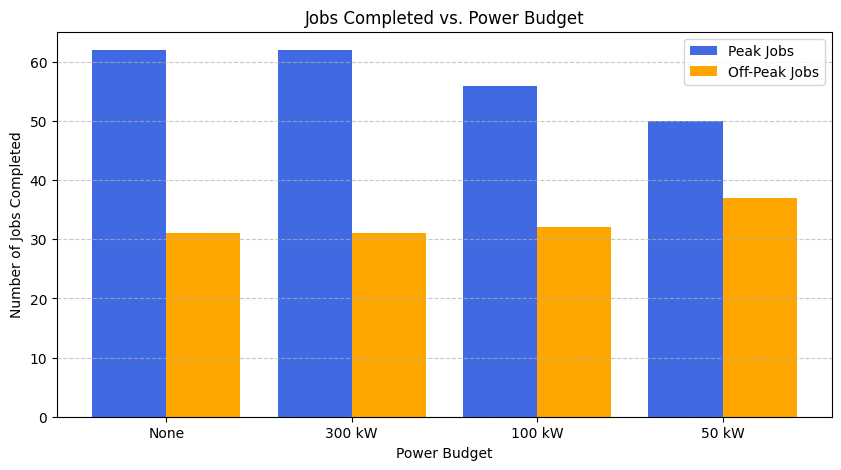

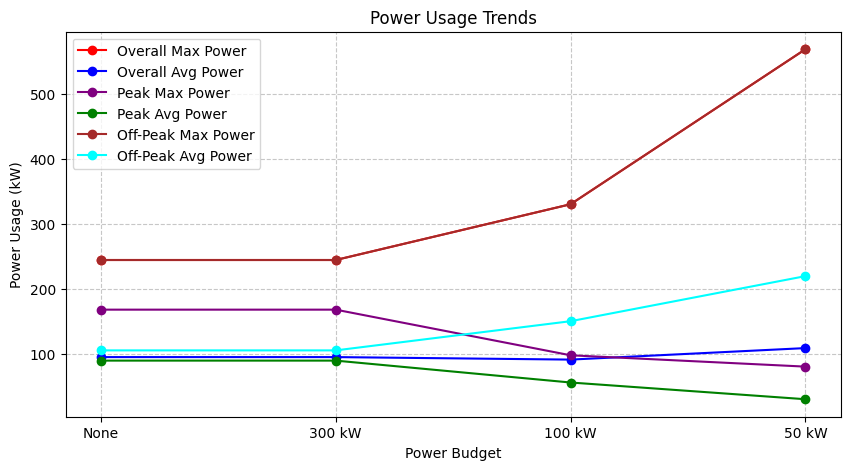

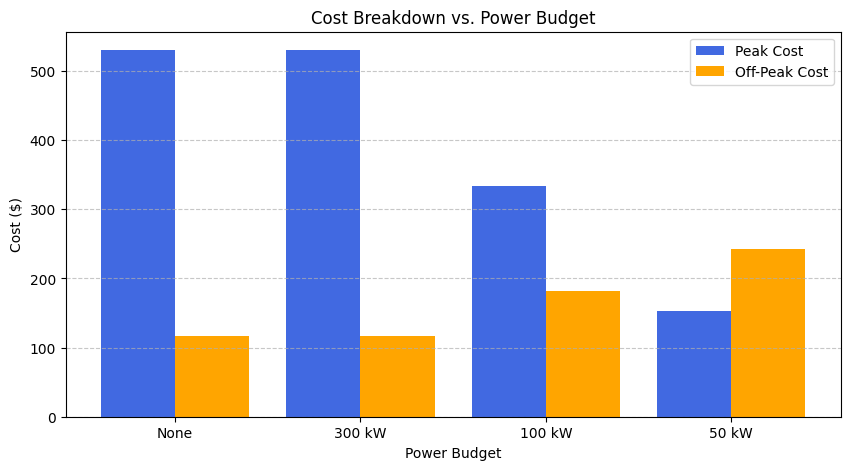

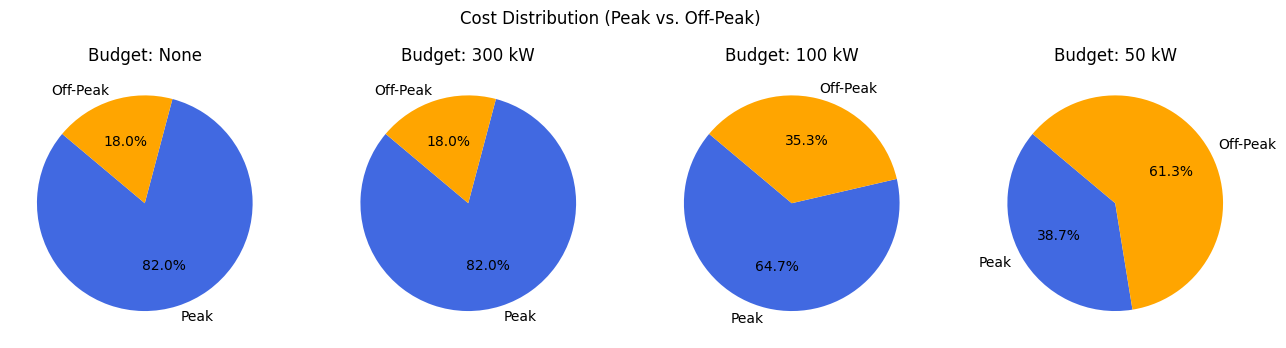

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the simulation results
budgets = ["None", "300 kW", "100 kW", "50 kW"]
total_jobs = [93, 93, 88, 87]
peak_jobs = [62, 62, 56, 50]
off_peak_jobs = [31, 31, 32, 37]

max_power = [244.56, 244.56, 330.49, 569.33]
avg_power = [94.97, 94.97, 91.11, 108.84]
peak_max_power = [168.07, 168.07, 97.76, 80.29]
peak_avg_power = [89.55, 89.55, 55.81, 30.06]
off_peak_max_power = [244.56, 244.56, 330.49, 569.33]
off_peak_avg_power = [105.30, 105.30, 150.27, 219.72]

total_cost = [646.82, 646.82, 515.95, 395.19]
peak_cost = [530.27, 530.27, 333.98, 152.83]
off_peak_cost = [116.55, 116.55, 181.98, 242.36]

# Plot: Jobs Completed vs. Power Budget
plt.figure(figsize=(10, 5))
bar_width = 0.4
x = np.arange(len(budgets))

plt.bar(x - bar_width/2, peak_jobs, bar_width, label="Peak Jobs", color='royalblue')
plt.bar(x + bar_width/2, off_peak_jobs, bar_width, label="Off-Peak Jobs", color='orange')

plt.xlabel("Power Budget")
plt.ylabel("Number of Jobs Completed")
plt.title("Jobs Completed vs. Power Budget")
plt.xticks(x, budgets)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot: Power Usage Trends
plt.figure(figsize=(10, 5))
plt.plot(budgets, max_power, marker='o', label="Overall Max Power", color='red')
plt.plot(budgets, avg_power, marker='o', label="Overall Avg Power", color='blue')
plt.plot(budgets, peak_max_power, marker='o', label="Peak Max Power", color='purple')
plt.plot(budgets, peak_avg_power, marker='o', label="Peak Avg Power", color='green')
plt.plot(budgets, off_peak_max_power, marker='o', label="Off-Peak Max Power", color='brown')
plt.plot(budgets, off_peak_avg_power, marker='o', label="Off-Peak Avg Power", color='cyan')

plt.xlabel("Power Budget")
plt.ylabel("Power Usage (kW)")
plt.title("Power Usage Trends")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot: Cost Breakdown vs. Power Budget
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, peak_cost, bar_width, label="Peak Cost", color='royalblue')
plt.bar(x + bar_width/2, off_peak_cost, bar_width, label="Off-Peak Cost", color='orange')

plt.xlabel("Power Budget")
plt.ylabel("Cost ($)")
plt.title("Cost Breakdown vs. Power Budget")
plt.xticks(x, budgets)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pie Charts: Peak vs. Off-Peak Cost Ratios
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].pie([peak_cost[i], off_peak_cost[i]], labels=["Peak", "Off-Peak"],
                autopct='%1.1f%%', colors=['royalblue', 'orange'], startangle=140)
    axes[i].set_title(f"Budget: {budgets[i]}")

plt.suptitle("Cost Distribution (Peak vs. Off-Peak)")
plt.show()


# Power aware scheduling with job wait time analysis

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from heapq import heappush, heappop

class PowerAwareScheduler:
    def __init__(
        self,
        total_nodes: int = 1000,
        peak_power_budget: float = None,  # in kW
        peak_start: int = 6,
        peak_end: int = 22,
        base_rate: float = 0.12,     # $/kWh
        peak_rate_multiplier: float = 3
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.peak_power_budget = peak_power_budget
        self.peak_start = peak_start
        self.peak_end = peak_end
        self.base_rate = base_rate
        self.peak_rate = base_rate * peak_rate_multiplier
        
        # Event queue for efficient time advancement
        self.event_queue = []
        self.running_jobs = {}  # job_id -> job_dict
        self.current_time = None
        
        # Metrics tracking
        self.total_cost = 0
        self.peak_cost = 0
        self.offpeak_cost = 0
        self.completed_jobs = []
        self.power_log = []

    def is_peak_hour(self, time: datetime) -> bool:
        return self.peak_start <= time.hour < self.peak_end

    def get_power_rate(self, time: datetime) -> float:
        return self.peak_rate if self.is_peak_hour(time) else self.base_rate

    def calculate_current_power(self) -> float:
        if not self.running_jobs:
            return 0.0
        return sum(job['power_kw'] for job in self.running_jobs.values())

    def can_schedule_job(self, job: Dict) -> bool:
        """Check if job can be scheduled considering nodes and power budget"""
        # First check node availability
        if job['num_nodes_alloc'] > self.available_nodes:
            return False
            
        # During peak hours, enforce power budget
        if self.is_peak_hour(self.current_time) and self.peak_power_budget:
            current_power = self.calculate_current_power()
            return (current_power + job['power_kw']) <= self.peak_power_budget
            
        # During off-peak, only check node availability
        return True

    def simulate(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Run power-aware scheduling simulation"""
        # Preprocess jobs
        jobs = df.copy()
        jobs['power_kw'] = jobs['mean_node_power'] * jobs['num_nodes_alloc'] / 1000
        
        # Sort jobs by power consumption for better scheduling decisions
        jobs = jobs.sort_values('power_kw', ascending=False)
        
        # Initialize simulation
        self.current_time = jobs['submit_time'].min()
        end_time = self.current_time + timedelta(days=1)
        
        # Add initial job submissions to event queue
        for _, job in jobs.iterrows():
            heappush(self.event_queue, (job['submit_time'], 'submit', job.to_dict()))
        
        # Track power usage over time
        self.power_usage = []
        
        # Main simulation loop
        while self.event_queue and self.current_time < end_time:
            event_time, event_type, job = heappop(self.event_queue)
            self.current_time = event_time
            
            # Log power usage
            current_power = self.calculate_current_power()
            self.power_usage.append({
                'time': self.current_time,
                'power_usage': current_power,
                'is_peak': self.is_peak_hour(self.current_time),
                'num_running': len(self.running_jobs)
            })
            
            if event_type == 'submit':
                self._handle_submission(job)
            elif event_type == 'complete':
                self._handle_completion(job)
        
        # Calculate final metrics
        peak_power_usage = [log['power_usage'] for log in self.power_usage if log['is_peak']]
        offpeak_power_usage = [log['power_usage'] for log in self.power_usage if not log['is_peak']]
        
        # Calculate wait time statistics
        completed_jobs_df = pd.DataFrame(self.completed_jobs)
        
        if not completed_jobs_df.empty:
            peak_jobs = completed_jobs_df[completed_jobs_df['is_peak']]
            offpeak_jobs = completed_jobs_df[~completed_jobs_df['is_peak']]
            
            # Wait time stats for different job types
            wait_stats = {
                'overall': {
                    'avg': completed_jobs_df['wait_time'].mean(),
                    'median': completed_jobs_df['wait_time'].median(),
                    'max': completed_jobs_df['wait_time'].max(),
                    'min': completed_jobs_df['wait_time'].min()
                },
                'peak': {
                    'avg': peak_jobs['wait_time'].mean() if not peak_jobs.empty else 0,
                    'median': peak_jobs['wait_time'].median() if not peak_jobs.empty else 0,
                    'max': peak_jobs['wait_time'].max() if not peak_jobs.empty else 0,
                    'min': peak_jobs['wait_time'].min() if not peak_jobs.empty else 0
                },
                'offpeak': {
                    'avg': offpeak_jobs['wait_time'].mean() if not offpeak_jobs.empty else 0,
                    'median': offpeak_jobs['wait_time'].median() if not offpeak_jobs.empty else 0,
                    'max': offpeak_jobs['wait_time'].max() if not offpeak_jobs.empty else 0,
                    'min': offpeak_jobs['wait_time'].min() if not offpeak_jobs.empty else 0
                }
            }
            
            # Additional wait time analysis by job power consumption
            completed_jobs_df['power_category'] = pd.qcut(completed_jobs_df['power_kw'], 
                                                        q=3, 
                                                        labels=['low', 'medium', 'high'])
            wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
                'mean', 'median', 'max', 'min', 'count'
            ]).to_dict('index')
        else:
            wait_stats = {'overall': {}, 'peak': {}, 'offpeak': {}}
            wait_by_power = {}
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_usage) if self.power_usage else 0,
            'avg_power': np.mean([log['power_usage'] for log in self.power_usage]) if self.power_usage else 0,
            'peak_max_power': max(peak_power_usage) if peak_power_usage else 0,
            'peak_avg_power': np.mean(peak_power_usage) if peak_power_usage else 0,
            'offpeak_max_power': max(offpeak_power_usage) if offpeak_power_usage else 0,
            'offpeak_avg_power': np.mean(offpeak_power_usage) if offpeak_power_usage else 0,
            'wait_stats': wait_stats,
            'wait_by_power': wait_by_power,
            'power_usage': pd.DataFrame(self.power_usage)
        }
        
        return pd.DataFrame(self.completed_jobs), summary

    def _handle_submission(self, job: Dict) -> None:
        """Handle job submission with power-aware scheduling"""
        is_peak = self.is_peak_hour(self.current_time)
        power_kw = job['power_kw']
        
        # During peak hours with power budget
        if is_peak and self.peak_power_budget:
            current_power = self.calculate_current_power()
            
            # If adding this job would exceed budget, delay to off-peak
            if (current_power + power_kw > self.peak_power_budget):
                # Find next off-peak hour
                next_offpeak = self.current_time.replace(hour=self.peak_end, minute=0, second=0)
                if next_offpeak <= self.current_time:
                    next_offpeak += timedelta(days=1)
                heappush(self.event_queue, (next_offpeak, 'submit', job))
                return
        
        # Check if we can schedule now
        if self.can_schedule_job(job):
            self._start_job(job)
        else:
            # Try again in 5 minutes
            heappush(self.event_queue, (self.current_time + timedelta(minutes=5), 'submit', job))

    def _handle_completion(self, job: Dict) -> None:
        if job['job_id'] in self.running_jobs:
            completed_job = self.running_jobs.pop(job['job_id'])
            self.available_nodes += completed_job['num_nodes_alloc']
            self.completed_jobs.append(completed_job)

    def _start_job(self, job: Dict) -> None:
        """Start a job and record its metrics including wait time"""
        self.available_nodes -= job['num_nodes_alloc']
        
        job['start_time'] = self.current_time
        job['end_time'] = self.current_time + timedelta(seconds=job['run_time'])
        job['wait_time'] = (job['start_time'] - job['submit_time']).total_seconds()
        
        # Calculate power cost
        duration_hours = job['run_time'] / 3600
        rate = self.get_power_rate(self.current_time)
        cost = job['power_kw'] * duration_hours * rate
        
        job['power_cost'] = cost
        job['is_peak'] = self.is_peak_hour(self.current_time)
        
        if job['is_peak']:
            self.peak_cost += cost
        else:
            self.offpeak_cost += cost
        
        self.running_jobs[job['job_id']] = job
        heappush(self.event_queue, (job['end_time'], 'complete', job))

    def _schedule_queued_jobs(self, jobs: pd.DataFrame) -> None:
        is_peak = self.is_peak_hour(self.current_time)
        current_power = self.calculate_current_power()
        
        if is_peak and self.peak_power_budget and current_power >= self.peak_power_budget:
            return

    def _generate_metrics(self) -> Tuple[pd.DataFrame, Dict]:
        metrics_df = pd.DataFrame(self.completed_jobs)
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_log),
            'avg_power': np.mean([log['power_usage'] for log in self.power_log])
        }
        
        return metrics_df, summary

def run_simulation(df: pd.DataFrame, power_budget: float = None) -> None:
    """Run simulation and print results"""
    scheduler = PowerAwareScheduler(peak_power_budget=power_budget)
    metrics_df, summary = scheduler.simulate(df)
    
    print("\nSimulation Results")
    print("-" * 50)
    print(f"Power Budget: {'None' if power_budget is None else f'{power_budget} kW'}")
    
    print(f"\nJob Distribution:")
    print(f"Total Jobs Completed: {summary['total_jobs']}")
    print(f"Peak Hours Jobs: {summary['peak_jobs']}")
    print(f"Off-Peak Hours Jobs: {summary['offpeak_jobs']}")
    
    print(f"\nPower Usage:")
    print(f"Overall Maximum Power: {summary['max_power']:.2f} kW")
    print(f"Overall Average Power: {summary['avg_power']:.2f} kW")
    print(f"Peak Hours - Max Power: {summary['peak_max_power']:.2f} kW")
    print(f"Peak Hours - Avg Power: {summary['peak_avg_power']:.2f} kW")
    print(f"Off-Peak Hours - Max Power: {summary['offpeak_max_power']:.2f} kW")
    print(f"Off-Peak Hours - Avg Power: {summary['offpeak_avg_power']:.2f} kW")
    
    print(f"\nPower Costs:")
    print(f"Total Cost: ${summary['total_cost']:.2f}")
    print(f"Peak Hours Cost: ${summary['peak_cost']:.2f}")
    print(f"Off-Peak Hours Cost: ${summary['offpeak_cost']:.2f}")
    
    print(f"\nWait Time Analysis (seconds):")
    print("\nOverall Wait Times:")
    for metric, value in summary['wait_stats']['overall'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
        
    print("\nPeak Hours Wait Times:")
    for metric, value in summary['wait_stats']['peak'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
        
    print("\nOff-Peak Hours Wait Times:")
    for metric, value in summary['wait_stats']['offpeak'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
        
    print("\nWait Times by Power Consumption:")
    for category, stats in summary['wait_by_power'].items():
        print(f"\n{category.capitalize()} Power Jobs:")
        for metric, value in stats.items():
            print(f"  {metric.capitalize()}: {value:.2f}")
    
    return metrics_df, summary

In [18]:
# Test different power budgets
budgets = [
    None,   # Baseline
    300,    # High budget
    100,    # Medium budget
    50      # Low budget
]

for budget in budgets:
    print(f"\nTesting {budget if budget else 'No'} kW budget:")
    metrics_df, summary = run_simulation(df, budget)


Testing No kW budget:

Simulation Results
--------------------------------------------------
Power Budget: None

Job Distribution:
Total Jobs Completed: 93
Peak Hours Jobs: 62
Off-Peak Hours Jobs: 31

Power Usage:
Overall Maximum Power: 244.56 kW
Overall Average Power: 94.97 kW
Peak Hours - Max Power: 168.07 kW
Peak Hours - Avg Power: 89.55 kW
Off-Peak Hours - Max Power: 244.56 kW
Off-Peak Hours - Avg Power: 105.30 kW

Power Costs:
Total Cost: $646.82
Peak Hours Cost: $530.27
Off-Peak Hours Cost: $116.55

Wait Time Analysis (seconds):

Overall Wait Times:
  Avg: 0.00
  Median: 0.00
  Max: 0.00
  Min: 0.00

Peak Hours Wait Times:
  Avg: 0.00
  Median: 0.00
  Max: 0.00
  Min: 0.00

Off-Peak Hours Wait Times:
  Avg: 0.00
  Median: 0.00
  Max: 0.00
  Min: 0.00

Wait Times by Power Consumption:

Low Power Jobs:
  Mean: 0.00
  Median: 0.00
  Max: 0.00
  Min: 0.00
  Count: 31.00

Medium Power Jobs:
  Mean: 0.00
  Median: 0.00
  Max: 0.00
  Min: 0.00
  Count: 31.00

High Power Jobs:
  Mean: 0

/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power 

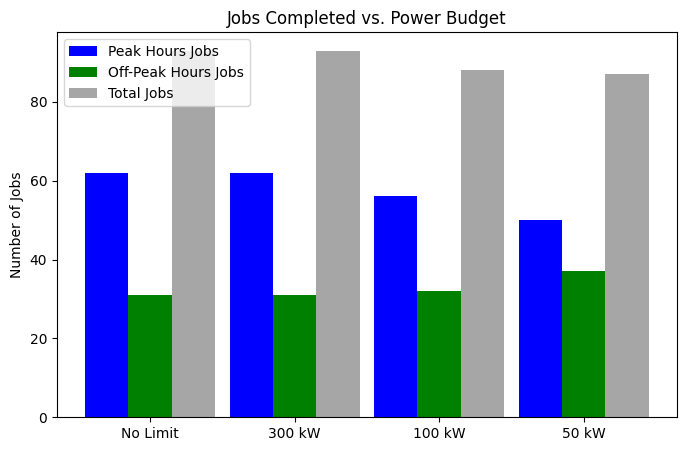

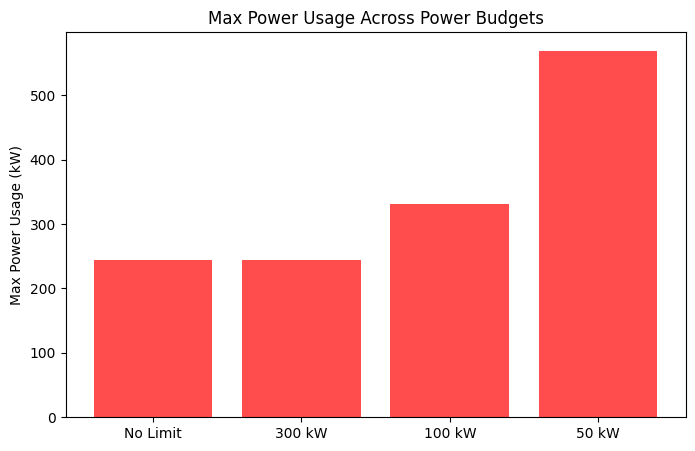

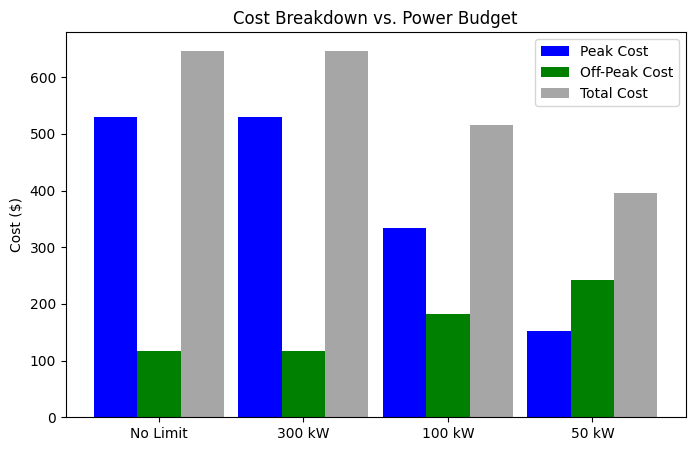

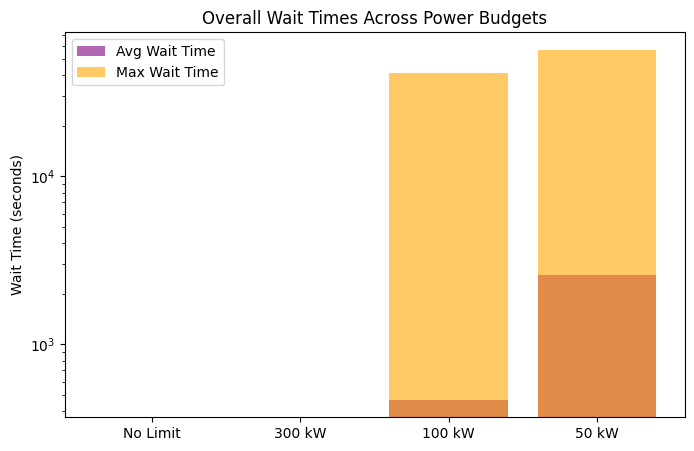

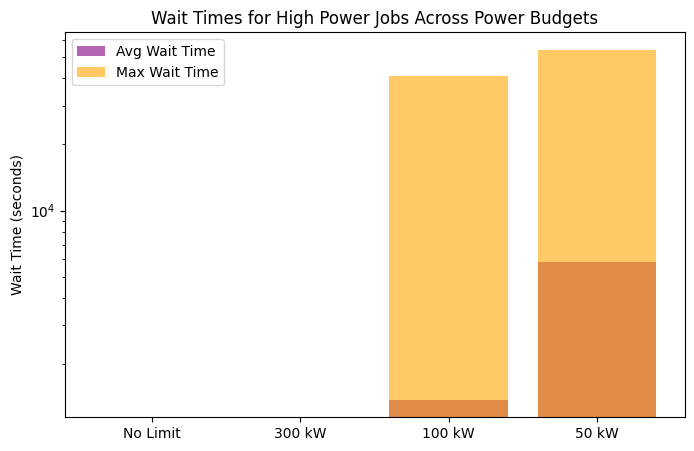

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Power budgets
power_budgets = ["No Limit", "300 kW", "100 kW", "50 kW"]

# Job distribution data
total_jobs = [93, 93, 88, 87]
peak_jobs = [62, 62, 56, 50]
off_peak_jobs = [31, 31, 32, 37]

# Power usage data (max values)
overall_max_power = [244.56, 244.56, 330.49, 569.33]

# Cost data
total_cost = [646.82, 646.82, 515.95, 395.19]
peak_cost = [530.27, 530.27, 333.98, 152.83]
off_peak_cost = [116.55, 116.55, 181.98, 242.36]

# Wait time data
overall_wait_avg = [0, 0, 467.85, 2588.95]
overall_wait_max = [0, 0, 41171, 56842]

# Wait times by job type (high power jobs)
high_power_wait_avg = [0, 0, 1372.37, 5806.79]
high_power_wait_max = [0, 0, 41171, 54038]

# Plot 1: Jobs Completed vs. Power Budget
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(power_budgets))
bar_width = 0.3

ax.bar(x - bar_width, peak_jobs, bar_width, label="Peak Hours Jobs", color='blue')
ax.bar(x, off_peak_jobs, bar_width, label="Off-Peak Hours Jobs", color='green')
ax.bar(x + bar_width, total_jobs, bar_width, label="Total Jobs", color='gray', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(power_budgets)
ax.set_ylabel("Number of Jobs")
ax.set_title("Jobs Completed vs. Power Budget")
ax.legend()
plt.show()

# Plot 2: Power Usage Trends (Max Power)
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(power_budgets, overall_max_power, color='red', alpha=0.7)
ax.set_ylabel("Max Power Usage (kW)")
ax.set_title("Max Power Usage Across Power Budgets")
plt.show()

# Plot 3: Cost Breakdown vs. Power Budget
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width, peak_cost, bar_width, label="Peak Cost", color='blue')
ax.bar(x, off_peak_cost, bar_width, label="Off-Peak Cost", color='green')
ax.bar(x + bar_width, total_cost, bar_width, label="Total Cost", color='gray', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(power_budgets)
ax.set_ylabel("Cost ($)")
ax.set_title("Cost Breakdown vs. Power Budget")
ax.legend()
plt.show()

# Plot 4: Overall Wait Time Analysis
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(power_budgets, overall_wait_avg, color='purple', alpha=0.6, label="Avg Wait Time")
ax.bar(power_budgets, overall_wait_max, color='orange', alpha=0.6, label="Max Wait Time")

ax.set_ylabel("Wait Time (seconds)")
ax.set_yscale("log")
ax.set_title("Overall Wait Times Across Power Budgets")
ax.legend()
plt.show()

# Plot 5: High Power Jobs Wait Time
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(power_budgets, high_power_wait_avg, color='purple', alpha=0.6, label="Avg Wait Time")
ax.bar(power_budgets, high_power_wait_max, color='orange', alpha=0.6, label="Max Wait Time")

ax.set_ylabel("Wait Time (seconds)")
ax.set_yscale("log")
ax.set_title("Wait Times for High Power Jobs Across Power Budgets")
ax.legend()
plt.show()


# Generate job dataset (2020 - 05/ 2020 - 10) 

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Dict, List, Tuple

class HPCJobGenerator:
    def __init__(self, start_date: datetime, end_date: datetime, seed: int = 42):
        self.start_date = start_date
        self.end_date = end_date
        self.seed = seed
        np.random.seed(seed)
        
        # Define base job types
        self.job_types = {
            'small_fast': {
                'nodes': (1, 4),
                'runtime': (300, 1800),     # 5-30 minutes
                'power': (100, 200),        # Watts per node
                'weight': 0.4,              # 40% of jobs
                'priority_dist': [0.1, 0.2, 0.4, 0.2, 0.1]  # Priority 1-5 distribution
            },
            'medium': {
                'nodes': (4, 16),
                'runtime': (1800, 7200),    # 30-120 minutes
                'power': (200, 400),        # Watts per node
                'weight': 0.3,              # 30% of jobs
                'priority_dist': [0.05, 0.15, 0.6, 0.15, 0.05]
            },
            'large_long': {
                'nodes': (16, 64),
                'runtime': (7200, 14400),   # 2-4 hours
                'power': (400, 800),        # Watts per node
                'weight': 0.2,              # 20% of jobs
                'priority_dist': [0.02, 0.08, 0.3, 0.4, 0.2]
            },
            'high_power': {
                'nodes': (32, 128),
                'runtime': (3600, 10800),   # 1-3 hours
                'power': (800, 1200),       # Watts per node
                'weight': 0.1,              # 10% of jobs
                'priority_dist': [0.01, 0.04, 0.15, 0.4, 0.4]
            }
        }
        
        # Define time-based patterns
        self.hourly_patterns = {
            'weekday': {
                0: 0.3, 1: 0.2, 2: 0.1, 3: 0.1, 4: 0.2, 5: 0.4,  # Early morning
                6: 0.6, 7: 0.8, 8: 1.0, 9: 1.2, 10: 1.3, 11: 1.2, # Morning
                12: 1.0, 13: 1.1, 14: 1.2, 15: 1.1, 16: 1.0, 17: 0.9, # Afternoon
                18: 0.7, 19: 0.6, 20: 0.5, 21: 0.4, 22: 0.3, 23: 0.3  # Evening
            },
            'weekend': {
                0: 0.2, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.2,
                6: 0.3, 7: 0.4, 8: 0.5, 9: 0.6, 10: 0.7, 11: 0.7,
                12: 0.6, 13: 0.6, 14: 0.5, 15: 0.5, 16: 0.4, 17: 0.4,
                18: 0.3, 19: 0.3, 20: 0.2, 21: 0.2, 22: 0.2, 23: 0.2
            }
        }
        
        # Define user departments with their characteristics
        self.departments = {
            'research': {
                'job_type_weights': {'small_fast': 0.5, 'medium': 0.3, 'large_long': 0.15, 'high_power': 0.05},
                'base_priority': [0.05, 0.15, 0.5, 0.2, 0.1],
                'weight': 0.4
            },
            'engineering': {
                'job_type_weights': {'small_fast': 0.3, 'medium': 0.4, 'large_long': 0.2, 'high_power': 0.1},
                'base_priority': [0.05, 0.1, 0.4, 0.3, 0.15],
                'weight': 0.3
            },
            'production': {
                'job_type_weights': {'small_fast': 0.2, 'medium': 0.3, 'large_long': 0.3, 'high_power': 0.2},
                'base_priority': [0.02, 0.08, 0.3, 0.4, 0.2],
                'weight': 0.3
            }
        }

    def _get_submission_count(self, date: datetime) -> int:
        """Calculate number of job submissions for a given date"""
        is_weekend = date.weekday() >= 5
        pattern = self.hourly_patterns['weekend' if is_weekend else 'weekday']
        
        # Base number of jobs per hour (higher during weekdays)
        base_jobs = 6 if is_weekend else 10
        
        # Monthly variation (more jobs during middle of month)
        day_of_month = date.day
        monthly_factor = 1.0 + 0.2 * np.sin(np.pi * day_of_month / 30)
        
        # Get hourly factor
        hourly_factor = pattern[date.hour]
        
        # Add some randomness
        random_factor = np.random.normal(1.0, 0.1)
        
        return int(base_jobs * hourly_factor * monthly_factor * random_factor)

    def _generate_job(self, submit_time: datetime, job_id: int) -> Dict:
        """Generate a single job with realistic characteristics"""
        # Select department
        department = np.random.choice(
            list(self.departments.keys()),
            p=[d['weight'] for d in self.departments.values()]
        )
        dept_info = self.departments[department]
        
        # Select job type based on department weights
        job_type = np.random.choice(
            list(dept_info['job_type_weights'].keys()),
            p=list(dept_info['job_type_weights'].values())
        )
        job_params = self.job_types[job_type]
        
        # Generate job parameters
        num_nodes = np.random.randint(*job_params['nodes'])
        runtime = np.random.uniform(*job_params['runtime'])
        power_per_node = np.random.uniform(*job_params['power'])
        
        # Priority combines department base priority and job type priority
        dept_priority = np.random.choice(range(1, 6), p=dept_info['base_priority'])
        job_priority = np.random.choice(range(1, 6), p=job_params['priority_dist'])
        final_priority = max(dept_priority, job_priority)  # Take higher priority
        
        # More realistic core allocation
        cores_per_node = 16  # Assuming 16 cores per node
        if job_type == 'small_fast':
            cores_per_task = np.random.choice([1, 2, 4])
        elif job_type == 'medium':
            cores_per_task = np.random.choice([2, 4, 8])
        else:
            cores_per_task = np.random.choice([8, 16])
        
        # Generate power profile variations
        power_profile = {
            'startup': power_per_node * np.random.uniform(0.7, 0.9),
            'compute': power_per_node,
            'cooldown': power_per_node * np.random.uniform(0.4, 0.6)
        }
        
        # Add possibility of job dependencies
        has_dependency = np.random.choice([True, False], p=[0.15, 0.85])
        dependency_job_id = job_id - np.random.randint(1, 10) if has_dependency and job_id > 10 else None
        
        return {
            'job_id': job_id,
            'submit_time': submit_time,
            'num_nodes_alloc': num_nodes,
            'run_time': runtime,
            'mean_node_power': power_per_node,
            'power_profile': power_profile,
            'cores_per_task': cores_per_task,
            'cores_per_node': cores_per_node,
            'shared': np.random.choice([0, 1], p=[0.7, 0.3]),
            'priority': final_priority,
            'job_type': job_type,
            'department': department,
            'dependency_job_id': dependency_job_id,
            'memory_gb': num_nodes * np.random.uniform(4, 32),  # Memory per node
            'state_reason': np.random.choice(
                ['None', 'TimeLimit', 'NodeFail'], 
                p=[0.92, 0.05, 0.03]
            ),
            'estimated_runtime': runtime * np.random.uniform(0.8, 1.2),  # User estimate
            'qos_level': np.random.choice(['standard', 'high', 'urgent'], 
                                        p=[0.7, 0.2, 0.1])
        }

    def generate_dataset(self) -> pd.DataFrame:
        """Generate the complete dataset"""
        jobs = []
        job_id = 1
        
        current_date = self.start_date
        while current_date <= self.end_date:
            # Get number of jobs for this hour
            num_jobs = self._get_submission_count(current_date)
            
            # Generate jobs for this hour
            submit_times = np.sort(np.random.uniform(
                0, 
                3600,  # seconds in an hour
                num_jobs
            ))
            
            for submit_time in submit_times:
                submit_datetime = current_date + timedelta(seconds=float(submit_time))
                jobs.append(self._generate_job(submit_datetime, job_id))
                job_id += 1
            
            current_date += timedelta(hours=1)
        
        # Convert to DataFrame
        df = pd.DataFrame(jobs)
        
        # Add some post-processing
        # Calculate actual runtime (some jobs might end early or hit limits)
        df['actual_runtime'] = df.apply(
            lambda x: min(x['run_time'], 
                        x['run_time'] * np.random.uniform(0.8, 1.1) if x['state_reason'] == 'TimeLimit'
                        else x['run_time']), 
            axis=1
        )
        
        # Sort by submit time
        df = df.sort_values('submit_time')
        
        return df

def generate_and_save_dataset(start_date: str, end_date: str, output_file: str) -> None:
    """Generate and save the dataset with given parameters"""
    start = datetime.strptime(start_date, '%Y-%m')
    end = datetime.strptime(end_date, '%Y-%m')
    
    generator = HPCJobGenerator(start, end)
    df = generator.generate_dataset()
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    
    # Print statistics
    print("\nDataset Statistics:")
    print("-" * 50)
    
    print(f"\nTotal number of jobs: {len(df)}")
    
    print("\nJob Type Distribution:")
    print(df['job_type'].value_counts(normalize=True).round(3) * 100)
    
    print("\nDepartment Distribution:")
    print(df['department'].value_counts(normalize=True).round(3) * 100)
    
    print("\nPriority Distribution:")
    print(df['priority'].value_counts(normalize=True).round(3) * 100)
    
    print("\nPower Usage Statistics (Watts per node):")
    print(df['mean_node_power'].describe().round(2))
    
    print("\nNode Allocation Statistics:")
    print(df['num_nodes_alloc'].describe().round(2))
    
    print("\nRuntime Statistics (hours):")
    print((df['run_time'] / 3600).describe().round(2))
    
    # Calculate peak concurrent power theoretical maximum
    total_power = (df['mean_node_power'] * df['num_nodes_alloc']).sum() / 1000
    print(f"\nTheoretical maximum power if all jobs ran simultaneously: {total_power:.2f} kW")

if __name__ == "__main__":
    # Generate dataset for May-October 2020
    generate_and_save_dataset(
        start_date='2020-05',
        end_date='2020-10',
        output_file='synthetic_hpc_jobs_2020.csv'
    )


Dataset Statistics:
--------------------------------------------------

Total number of jobs: 20980

Job Type Distribution:
job_type
small_fast    35.4
medium        32.0
large_long    21.5
high_power    11.1
Name: proportion, dtype: float64

Department Distribution:
department
research       39.5
production     30.7
engineering    29.8
Name: proportion, dtype: float64

Priority Distribution:
priority
4    38.5
3    31.9
5    26.7
2     2.6
1     0.2
Name: proportion, dtype: float64

Power Usage Statistics (Watts per node):
count    20980.00
mean       388.95
std        281.84
min        100.02
25%        169.73
50%        291.53
75%        538.22
max       1199.57
Name: mean_node_power, dtype: float64

Node Allocation Statistics:
count    20980.00
mean        20.96
std         27.29
min          1.00
25%          3.00
50%          9.00
75%         32.00
max        127.00
Name: num_nodes_alloc, dtype: float64

Runtime Statistics (hours):
count    20980.00
mean         1.37
std        

# Testing the crude algorithm on the new dataset

In [22]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# from power_aware_scheduler import PowerAwareScheduler, run_simulation

def prepare_dataset(file_path, start_date=None, num_days=1):
    """
    Prepare the synthetic dataset for the scheduler.
    """
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Convert submit_time to datetime
    df['submit_time'] = pd.to_datetime(df['submit_time'])
    
    # If start_date is provided, filter data
    if start_date:
        end_date = start_date + timedelta(days=num_days)
        df = df[
            (df['submit_time'] >= start_date) & 
            (df['submit_time'] < end_date)
        ]
    
    # Sort by submit time
    df = df.sort_values('submit_time')
    
    # Select and rename columns as needed for the scheduler
    scheduler_df = df[[
        'job_id',
        'submit_time',
        'num_nodes_alloc',
        'run_time',
        'mean_node_power',
        'priority'
    ]].copy()
    
    return scheduler_df

def run_multiple_simulations(df, power_budgets):
    """
    Run simulations with different power budgets and collect results
    """
    results = []
    
    for budget in power_budgets:
        print(f"\nRunning simulation with {budget} kW budget...")
        scheduler = PowerAwareScheduler(peak_power_budget=budget)
        metrics_df, summary = scheduler.simulate(df)
        
        # Add budget to summary for comparison
        summary['power_budget'] = budget
        results.append(summary)
    
    return results

def plot_comparison(results):
    """
    Plot comparison of different metrics across power budgets
    """
    budgets = [r['power_budget'] for r in results]
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Total Cost vs Power Budget
    axes[0, 0].plot(budgets, [r['total_cost'] for r in results], 'b-o')
    axes[0, 0].set_xlabel('Power Budget (kW)')
    axes[0, 0].set_ylabel('Total Cost ($)')
    axes[0, 0].set_title('Total Cost vs Power Budget')
    
    # Plot 2: Average Wait Time vs Power Budget
    axes[0, 1].plot(budgets, [r['wait_stats']['overall']['avg'] for r in results], 'r-o')
    axes[0, 1].set_xlabel('Power Budget (kW)')
    axes[0, 1].set_ylabel('Average Wait Time (s)')
    axes[0, 1].set_title('Average Wait Time vs Power Budget')
    
    # Plot 3: Peak Power Usage vs Power Budget
    axes[1, 0].plot(budgets, [r['peak_max_power'] for r in results], 'g-o')
    axes[1, 0].set_xlabel('Power Budget (kW)')
    axes[1, 0].set_ylabel('Peak Power Usage (kW)')
    axes[1, 0].set_title('Peak Power Usage vs Power Budget')
    
    # Plot 4: Number of Completed Jobs vs Power Budget
    axes[1, 1].plot(budgets, [r['total_jobs'] for r in results], 'm-o')
    axes[1, 1].set_xlabel('Power Budget (kW)')
    axes[1, 1].set_ylabel('Number of Completed Jobs')
    axes[1, 1].set_title('Completed Jobs vs Power Budget')
    
    plt.tight_layout()
    plt.savefig('power_budget_comparison.png')
    plt.close()

def main():
    # Load and prepare dataset
    file_path = 'synthetic_hpc_jobs_2020.csv'
    start_date = datetime(2020, 5, 1)  # Start with first day of data
    
    print("Preparing dataset...")
    df = prepare_dataset(file_path, start_date, num_days=1)
    
    print(f"Testing with {len(df)} jobs...")
    
    # Define power budgets to test (in kW)
    power_budgets = [None, 500, 300, 200, 100, 50]
    
    # Run simulations
    results = run_multiple_simulations(df, power_budgets)
    
    # Plot comparisons
    plot_comparison(results)
    
    # Print detailed comparison
    print("\nDetailed Comparison:")
    print("-" * 50)
    for result in results:
        budget = result['power_budget']
        budget_str = 'None' if budget is None else f'{budget} kW'
        print(f"\nPower Budget: {budget_str}")
        print(f"Total Cost: ${result['total_cost']:.2f}")
        print(f"Average Wait Time: {result['wait_stats']['overall']['avg']:.2f} seconds")
        print(f"Peak Power Usage: {result['peak_max_power']:.2f} kW")
        print(f"Completed Jobs: {result['total_jobs']}")

if __name__ == "__main__":
    main()

Preparing dataset...
Testing with 156 jobs...

Running simulation with None kW budget...

Running simulation with 500 kW budget...

Running simulation with 300 kW budget...

Running simulation with 200 kW budget...

Running simulation with 100 kW budget...

Running simulation with 50 kW budget...


/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power 


Detailed Comparison:
--------------------------------------------------

Power Budget: None
Total Cost: $1741.55
Average Wait Time: 0.00 seconds
Peak Power Usage: 682.79 kW
Completed Jobs: 154

Power Budget: 500 kW
Total Cost: $1628.72
Average Wait Time: 151.62 seconds
Peak Power Usage: 499.67 kW
Completed Jobs: 151

Power Budget: 300 kW
Total Cost: $1396.39
Average Wait Time: 1760.18 seconds
Peak Power Usage: 299.59 kW
Completed Jobs: 143

Power Budget: 200 kW
Total Cost: $1006.82
Average Wait Time: 1378.56 seconds
Peak Power Usage: 199.63 kW
Completed Jobs: 132

Power Budget: 100 kW
Total Cost: $656.63
Average Wait Time: 6879.57 seconds
Peak Power Usage: 103.47 kW
Completed Jobs: 121

Power Budget: 50 kW
Total Cost: $503.82
Average Wait Time: 8487.64 seconds
Peak Power Usage: 103.47 kW
Completed Jobs: 110


/tmp/ipykernel_6409/400734476.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data["Power Budget (kW)"], y=data["Total Cost ($)"], palette="Blues")
/tmp/ipykernel_6409/400734476.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data["Power Budget (kW)"], y=data["Peak Power Usage (kW)"], palette="Greens")


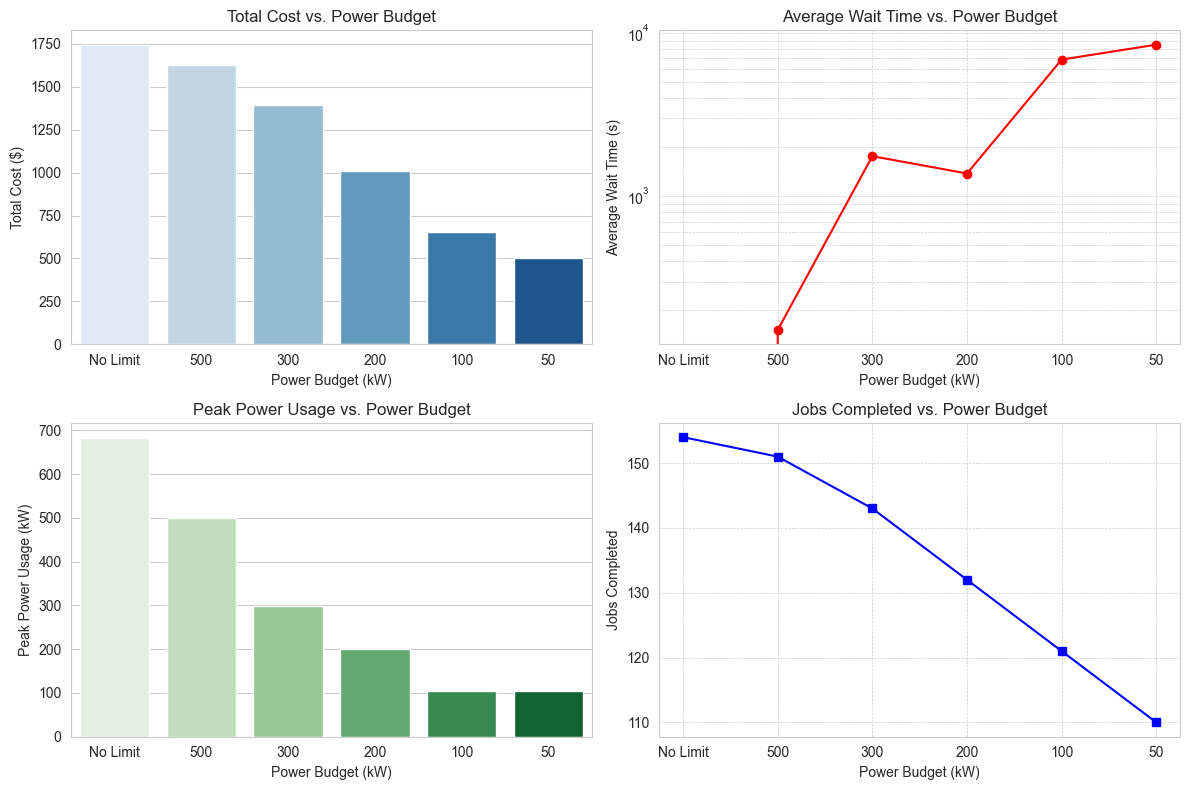

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
data = {
    "Power Budget (kW)": [None, 500, 300, 200, 100, 50],
    "Total Cost ($)": [1741.55, 1628.72, 1396.39, 1006.82, 656.63, 503.82],
    "Avg Wait Time (s)": [0, 151.62, 1760.18, 1378.56, 6879.57, 8487.64],
    "Peak Power Usage (kW)": [682.79, 499.67, 299.59, 199.63, 103.47, 103.47],
    "Completed Jobs": [154, 151, 143, 132, 121, 110]
}

# Convert None to "No Limit" for visualization
data["Power Budget (kW)"] = ["No Limit" if x is None else x for x in data["Power Budget (kW)"]]

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 1. Total Cost vs. Power Budget
plt.subplot(2, 2, 1)
sns.barplot(x=data["Power Budget (kW)"], y=data["Total Cost ($)"], palette="Blues")
plt.xlabel("Power Budget (kW)")
plt.ylabel("Total Cost ($)")
plt.title("Total Cost vs. Power Budget")

# 2. Average Wait Time vs. Power Budget (Log-Scale)
plt.subplot(2, 2, 2)
plt.plot(data["Power Budget (kW)"], data["Avg Wait Time (s)"], marker='o', linestyle='-', color='r')
plt.xlabel("Power Budget (kW)")
plt.ylabel("Average Wait Time (s)")
plt.title("Average Wait Time vs. Power Budget")
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 3. Peak Power Usage vs. Power Budget
plt.subplot(2, 2, 3)
sns.barplot(x=data["Power Budget (kW)"], y=data["Peak Power Usage (kW)"], palette="Greens")
plt.xlabel("Power Budget (kW)")
plt.ylabel("Peak Power Usage (kW)")
plt.title("Peak Power Usage vs. Power Budget")

# 4. Jobs Completed vs. Power Budget
plt.subplot(2, 2, 4)
plt.plot(data["Power Budget (kW)"], data["Completed Jobs"], marker='s', linestyle='-', color='b')
plt.xlabel("Power Budget (kW)")
plt.ylabel("Jobs Completed")
plt.title("Jobs Completed vs. Power Budget")
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Phase 1 improvement - immediate improvements in job selection and backfilling

Original

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from heapq import heappush, heappop

class PowerAwareScheduler:
    def __init__(
        self,
        total_nodes: int = 1000,
        peak_power_budget: float = None,  # in kW
        peak_start: int = 6,
        peak_end: int = 22,
        base_rate: float = 0.12,     # $/kWh
        peak_rate_multiplier: float = 3
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.peak_power_budget = peak_power_budget
        self.peak_start = peak_start
        self.peak_end = peak_end
        self.base_rate = base_rate
        self.peak_rate = base_rate * peak_rate_multiplier
        
        # Event queue for efficient time advancement
        self.event_queue = []
        self.running_jobs = {}  # job_id -> job_dict
        self.current_time = None
        
        # Metrics tracking
        self.total_cost = 0
        self.peak_cost = 0
        self.offpeak_cost = 0
        self.completed_jobs = []
        self.power_log = []

    def is_peak_hour(self, time: datetime) -> bool:
        return self.peak_start <= time.hour < self.peak_end

    def get_power_rate(self, time: datetime) -> float:
        return self.peak_rate if self.is_peak_hour(time) else self.base_rate

    def calculate_current_power(self) -> float:
        if not self.running_jobs:
            return 0.0
        return sum(job['power_kw'] for job in self.running_jobs.values())

    def can_schedule_job(self, job: Dict) -> bool:
        """Check if job can be scheduled considering nodes and power budget"""
        # First check node availability
        if job['num_nodes_alloc'] > self.available_nodes:
            return False
            
        # During peak hours, enforce power budget
        if self.is_peak_hour(self.current_time) and self.peak_power_budget:
            current_power = self.calculate_current_power()
            return (current_power + job['power_kw']) <= self.peak_power_budget
            
        # During off-peak, only check node availability
        return True

    def simulate(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Run power-aware scheduling simulation"""
        # Preprocess jobs
        jobs = df.copy()
        jobs['power_kw'] = jobs['mean_node_power'] * jobs['num_nodes_alloc'] / 1000
        
        # Sort jobs by power consumption for better scheduling decisions
        jobs = jobs.sort_values('power_kw', ascending=False)
        
        # Initialize simulation
        self.current_time = jobs['submit_time'].min()
        end_time = self.current_time + timedelta(days=1)
        
        # Add initial job submissions to event queue
        for _, job in jobs.iterrows():
            heappush(self.event_queue, (job['submit_time'], 'submit', job.to_dict()))
        
        # Track power usage over time
        self.power_usage = []
        
        # Main simulation loop
        while self.event_queue and self.current_time < end_time:
            event_time, event_type, job = heappop(self.event_queue)
            self.current_time = event_time
            
            # Log power usage
            current_power = self.calculate_current_power()
            self.power_usage.append({
                'time': self.current_time,
                'power_usage': current_power,
                'is_peak': self.is_peak_hour(self.current_time),
                'num_running': len(self.running_jobs)
            })
            
            if event_type == 'submit':
                self._handle_submission(job)
            elif event_type == 'complete':
                self._handle_completion(job)
        
        # Calculate final metrics
        peak_power_usage = [log['power_usage'] for log in self.power_usage if log['is_peak']]
        offpeak_power_usage = [log['power_usage'] for log in self.power_usage if not log['is_peak']]
        
        # Calculate wait time statistics
        completed_jobs_df = pd.DataFrame(self.completed_jobs)
        
        if not completed_jobs_df.empty:
            peak_jobs = completed_jobs_df[completed_jobs_df['is_peak']]
            offpeak_jobs = completed_jobs_df[~completed_jobs_df['is_peak']]
            
            # Wait time stats for different job types
            wait_stats = {
                'overall': {
                    'avg': completed_jobs_df['wait_time'].mean(),
                    'median': completed_jobs_df['wait_time'].median(),
                    'max': completed_jobs_df['wait_time'].max(),
                    'min': completed_jobs_df['wait_time'].min()
                },
                'peak': {
                    'avg': peak_jobs['wait_time'].mean() if not peak_jobs.empty else 0,
                    'median': peak_jobs['wait_time'].median() if not peak_jobs.empty else 0,
                    'max': peak_jobs['wait_time'].max() if not peak_jobs.empty else 0,
                    'min': peak_jobs['wait_time'].min() if not peak_jobs.empty else 0
                },
                'offpeak': {
                    'avg': offpeak_jobs['wait_time'].mean() if not offpeak_jobs.empty else 0,
                    'median': offpeak_jobs['wait_time'].median() if not offpeak_jobs.empty else 0,
                    'max': offpeak_jobs['wait_time'].max() if not offpeak_jobs.empty else 0,
                    'min': offpeak_jobs['wait_time'].min() if not offpeak_jobs.empty else 0
                }
            }
            
            # Additional wait time analysis by job power consumption
            completed_jobs_df['power_category'] = pd.qcut(completed_jobs_df['power_kw'], 
                                                        q=3, 
                                                        labels=['low', 'medium', 'high'])
            wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
                'mean', 'median', 'max', 'min', 'count'
            ]).to_dict('index')
        else:
            wait_stats = {'overall': {}, 'peak': {}, 'offpeak': {}}
            wait_by_power = {}
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_usage) if self.power_usage else 0,
            'avg_power': np.mean([log['power_usage'] for log in self.power_usage]) if self.power_usage else 0,
            'peak_max_power': max(peak_power_usage) if peak_power_usage else 0,
            'peak_avg_power': np.mean(peak_power_usage) if peak_power_usage else 0,
            'offpeak_max_power': max(offpeak_power_usage) if offpeak_power_usage else 0,
            'offpeak_avg_power': np.mean(offpeak_power_usage) if offpeak_power_usage else 0,
            'wait_stats': wait_stats,
            'wait_by_power': wait_by_power,
            'power_usage': pd.DataFrame(self.power_usage)
        }
        
        return pd.DataFrame(self.completed_jobs), summary

    def _handle_submission(self, job: Dict) -> None:
        """Handle job submission with power-aware scheduling"""
        is_peak = self.is_peak_hour(self.current_time)
        power_kw = job['power_kw']
        
        # During peak hours with power budget
        if is_peak and self.peak_power_budget:
            current_power = self.calculate_current_power()
            
            # If adding this job would exceed budget, delay to off-peak
            if (current_power + power_kw > self.peak_power_budget):
                # Find next off-peak hour
                next_offpeak = self.current_time.replace(hour=self.peak_end, minute=0, second=0)
                if next_offpeak <= self.current_time:
                    next_offpeak += timedelta(days=1)
                heappush(self.event_queue, (next_offpeak, 'submit', job))
                return
        
        # Check if we can schedule now
        if self.can_schedule_job(job):
            self._start_job(job)
        else:
            # Try again in 5 minutes
            heappush(self.event_queue, (self.current_time + timedelta(minutes=5), 'submit', job))

    def _handle_completion(self, job: Dict) -> None:
        if job['job_id'] in self.running_jobs:
            completed_job = self.running_jobs.pop(job['job_id'])
            self.available_nodes += completed_job['num_nodes_alloc']
            self.completed_jobs.append(completed_job)

    def _start_job(self, job: Dict) -> None:
        """Start a job and record its metrics including wait time"""
        self.available_nodes -= job['num_nodes_alloc']
        
        job['start_time'] = self.current_time
        job['end_time'] = self.current_time + timedelta(seconds=job['run_time'])
        job['wait_time'] = (job['start_time'] - job['submit_time']).total_seconds()
        
        # Calculate power cost
        duration_hours = job['run_time'] / 3600
        rate = self.get_power_rate(self.current_time)
        cost = job['power_kw'] * duration_hours * rate
        
        job['power_cost'] = cost
        job['is_peak'] = self.is_peak_hour(self.current_time)
        
        if job['is_peak']:
            self.peak_cost += cost
        else:
            self.offpeak_cost += cost
        
        self.running_jobs[job['job_id']] = job
        heappush(self.event_queue, (job['end_time'], 'complete', job))

    def _schedule_queued_jobs(self, jobs: pd.DataFrame) -> None:
        is_peak = self.is_peak_hour(self.current_time)
        current_power = self.calculate_current_power()
        
        if is_peak and self.peak_power_budget and current_power >= self.peak_power_budget:
            return

    def _generate_metrics(self) -> Tuple[pd.DataFrame, Dict]:
        metrics_df = pd.DataFrame(self.completed_jobs)
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_log),
            'avg_power': np.mean([log['power_usage'] for log in self.power_log])
        }
        
        return metrics_df, summary

def run_simulation(df: pd.DataFrame, power_budget: float = None) -> None:
    """Run simulation and print results"""
    scheduler = PowerAwareScheduler(peak_power_budget=power_budget)
    metrics_df, summary = scheduler.simulate(df)
    
    print("\nSimulation Results")
    print("-" * 50)
    print(f"Power Budget: {'None' if power_budget is None else f'{power_budget} kW'}")
    
    print(f"\nJob Distribution:")
    print(f"Total Jobs Completed: {summary['total_jobs']}")
    print(f"Peak Hours Jobs: {summary['peak_jobs']}")
    print(f"Off-Peak Hours Jobs: {summary['offpeak_jobs']}")
    
    print(f"\nPower Usage:")
    print(f"Overall Maximum Power: {summary['max_power']:.2f} kW")
    print(f"Overall Average Power: {summary['avg_power']:.2f} kW")
    print(f"Peak Hours - Max Power: {summary['peak_max_power']:.2f} kW")
    print(f"Peak Hours - Avg Power: {summary['peak_avg_power']:.2f} kW")
    print(f"Off-Peak Hours - Max Power: {summary['offpeak_max_power']:.2f} kW")
    print(f"Off-Peak Hours - Avg Power: {summary['offpeak_avg_power']:.2f} kW")
    
    print(f"\nPower Costs:")
    print(f"Total Cost: ${summary['total_cost']:.2f}")
    print(f"Peak Hours Cost: ${summary['peak_cost']:.2f}")
    print(f"Off-Peak Hours Cost: ${summary['offpeak_cost']:.2f}")
    
    print(f"\nWait Time Analysis (seconds):")
    print("\nOverall Wait Times:")
    for metric, value in summary['wait_stats']['overall'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
        
    print("\nPeak Hours Wait Times:")
    for metric, value in summary['wait_stats']['peak'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
        
    print("\nOff-Peak Hours Wait Times:")
    for metric, value in summary['wait_stats']['offpeak'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
        
    print("\nWait Times by Power Consumption:")
    for category, stats in summary['wait_by_power'].items():
        print(f"\n{category.capitalize()} Power Jobs:")
        for metric, value in stats.items():
            print(f"  {metric.capitalize()}: {value:.2f}")
    
    return metrics_df, summary

Enhanced

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from heapq import heappush, heappop

class EnhancedPowerAwareScheduler:
    def __init__(
        self,
        total_nodes: int = 1000,
        peak_power_budget: float = None,  # in kW
        peak_start: int = 6,
        peak_end: int = 22,
        base_rate: float = 0.12,     # $/kWh
        peak_rate_multiplier: float = 3
    ):
        self.total_nodes = total_nodes
        self.available_nodes = total_nodes
        self.peak_power_budget = peak_power_budget
        self.peak_start = peak_start
        self.peak_end = peak_end
        self.base_rate = base_rate
        self.peak_rate = base_rate * peak_rate_multiplier
        
        # Event queue for efficient time advancement
        self.event_queue = []
        self.running_jobs = {}  # job_id -> job_dict
        self.queued_jobs = []   # List of jobs waiting to be scheduled
        self.current_time = None
        
        # Metrics tracking
        self.total_cost = 0
        self.peak_cost = 0
        self.offpeak_cost = 0
        self.completed_jobs = []
        self.power_log = []

    def is_peak_hour(self, time: datetime) -> bool:
        return self.peak_start <= time.hour < self.peak_end

    def get_power_rate(self, time: datetime) -> float:
        return self.peak_rate if self.is_peak_hour(time) else self.base_rate

    def calculate_current_power(self) -> float:
        if not self.running_jobs:
            return 0.0
        return sum(job['power_kw'] for job in self.running_jobs.values())

    def calculate_job_score(self, job: Dict) -> float:
        # Power cost factor (higher cost = lower score)
        power_kw = job['mean_node_power'] * job['num_nodes_alloc'] / 1000
        duration_hours = job['run_time'] / 3600
        
        # Calculate potential cost based on current time
        potential_cost = power_kw * duration_hours * self.get_power_rate(self.current_time)
        cost_factor = 1.0 / (1.0 + potential_cost)  # Normalize cost impact
        
        # Power efficiency (lower power per node is better)
        power_efficiency = 1.0 / (job['mean_node_power'] + 1)
        
        # Wait time factor
        wait_time = (self.current_time - job['submit_time']).total_seconds()
        wait_factor = min(wait_time / 3600, 24)
        
        # Priority factor
        priority_weight = job['priority'] / 5.0 if 'priority' in job else 1.0
        
        # Adjusted weights
        return (
            cost_factor * 0.4 +
            power_efficiency * 0.3 +
            (wait_factor / 24.0) * 0.2 +
            priority_weight * 0.1
        )

    def can_schedule_job(self, job: Dict) -> bool:
        """Check if job can be scheduled considering nodes and power budget"""
        # First check node availability
        if job['num_nodes_alloc'] > self.available_nodes:
            return False
            
        # During peak hours, enforce power budget
        if self.is_peak_hour(self.current_time) and self.peak_power_budget:
            current_power = self.calculate_current_power()
            power_kw = job['power_kw']
            return (current_power + power_kw) <= self.peak_power_budget
            
        # During off-peak, only check node availability
        return True

    def simulate(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Run power-aware scheduling simulation"""
        # Preprocess jobs
        jobs = df.copy()
        jobs['power_kw'] = jobs['mean_node_power'] * jobs['num_nodes_alloc'] / 1000
        
        # Sort jobs by power consumption for better scheduling decisions
        jobs = jobs.sort_values('power_kw', ascending=False)
        
        # Initialize simulation
        self.current_time = jobs['submit_time'].min()
        end_time = jobs['submit_time'].max() + timedelta(days=1)
        
        # Add initial job submissions to event queue
        for _, job in jobs.iterrows():
            heappush(self.event_queue, (job['submit_time'], 'submit', job.to_dict()))
        
        # Track power usage over time
        self.power_usage = []
        
        # Main simulation loop
        while self.event_queue and self.current_time < end_time:
            event_time, event_type, job = heappop(self.event_queue)
            self.current_time = event_time
            
            # Log power usage
            current_power = self.calculate_current_power()
            self.power_usage.append({
                'time': self.current_time,
                'power_usage': current_power,
                'is_peak': self.is_peak_hour(self.current_time),
                'num_running': len(self.running_jobs)
            })
            
            if event_type == 'submit':
                self._handle_submission(job)
            elif event_type == 'complete':
                self._handle_completion(job)
                # Try to schedule queued jobs after completion
                self._schedule_queued_jobs()
        
        # Calculate metrics
        return self._generate_metrics()

    def _handle_submission(self, job: Dict) -> None:
        """Handle job submission with power-aware scheduling"""
        if self.can_schedule_job(job):
            self._start_job(job)
        else:
            # Add to queue for scoring-based scheduling
            self.queued_jobs.append(job)
            
            # Try to schedule highest scoring queued jobs
            self._schedule_queued_jobs()

    def _handle_completion(self, job: Dict) -> None:
        """Handle job completion"""
        if job['job_id'] in self.running_jobs:
            completed_job = self.running_jobs.pop(job['job_id'])
            self.available_nodes += completed_job['num_nodes_alloc']
            self.completed_jobs.append(completed_job)

    def _start_job(self, job: Dict) -> None:
        """Start a job and record its metrics"""
        self.available_nodes -= job['num_nodes_alloc']
        
        job['start_time'] = self.current_time
        job['end_time'] = self.current_time + timedelta(seconds=job['run_time'])
        job['wait_time'] = (job['start_time'] - job['submit_time']).total_seconds()
        
        # Calculate power cost
        duration_hours = job['run_time'] / 3600
        rate = self.get_power_rate(self.current_time)
        cost = job['power_kw'] * duration_hours * rate
        
        job['power_cost'] = cost
        job['is_peak'] = self.is_peak_hour(self.current_time)
        
        if job['is_peak']:
            self.peak_cost += cost
        else:
            self.offpeak_cost += cost
        
        self.running_jobs[job['job_id']] = job
        heappush(self.event_queue, (job['end_time'], 'complete', job))

    def _schedule_queued_jobs(self) -> None:
        if not self.queued_jobs:
            return
            
        is_peak = self.is_peak_hour(self.current_time)
        scored_jobs = []
        
        for job in self.queued_jobs:
            base_score = self.calculate_job_score(job)
            
            # Penalize high-power jobs during peak hours
            if is_peak:
                power_kw = job['mean_node_power'] * job['num_nodes_alloc'] / 1000
                if power_kw > 50:  # High power threshold
                    base_score *= 0.7  # 30% penalty
            
            scored_jobs.append((base_score, job))

    def _generate_metrics(self) -> Tuple[pd.DataFrame, Dict]:
        """Generate final metrics and summary"""
        completed_jobs_df = pd.DataFrame(self.completed_jobs)
        
        if not completed_jobs_df.empty:
            peak_jobs = completed_jobs_df[completed_jobs_df['is_peak']]
            offpeak_jobs = completed_jobs_df[~completed_jobs_df['is_peak']]
            
            wait_stats = {
                'overall': {
                    'avg': completed_jobs_df['wait_time'].mean(),
                    'median': completed_jobs_df['wait_time'].median(),
                    'max': completed_jobs_df['wait_time'].max(),
                    'min': completed_jobs_df['wait_time'].min()
                },
                'peak': {
                    'avg': peak_jobs['wait_time'].mean() if not peak_jobs.empty else 0,
                    'median': peak_jobs['wait_time'].median() if not peak_jobs.empty else 0,
                    'max': peak_jobs['wait_time'].max() if not peak_jobs.empty else 0,
                    'min': peak_jobs['wait_time'].min() if not peak_jobs.empty else 0
                },
                'offpeak': {
                    'avg': offpeak_jobs['wait_time'].mean() if not offpeak_jobs.empty else 0,
                    'median': offpeak_jobs['wait_time'].median() if not offpeak_jobs.empty else 0,
                    'max': offpeak_jobs['wait_time'].max() if not offpeak_jobs.empty else 0,
                    'min': offpeak_jobs['wait_time'].min() if not offpeak_jobs.empty else 0
                }
            }
            
            # Additional wait time analysis by job power consumption
            completed_jobs_df['power_category'] = pd.qcut(
                completed_jobs_df['power_kw'], 
                q=3, 
                labels=['low', 'medium', 'high']
            )
            wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
                'mean', 'median', 'max', 'min', 'count'
            ]).to_dict('index')
        else:
            wait_stats = {'overall': {}, 'peak': {}, 'offpeak': {}}
            wait_by_power = {}
        
        peak_power_usage = [log['power_usage'] for log in self.power_usage if log['is_peak']]
        offpeak_power_usage = [log['power_usage'] for log in self.power_usage if not log['is_peak']]
        
        summary = {
            'total_jobs': len(self.completed_jobs),
            'peak_jobs': sum(1 for job in self.completed_jobs if job['is_peak']),
            'offpeak_jobs': sum(1 for job in self.completed_jobs if not job['is_peak']),
            'total_cost': self.peak_cost + self.offpeak_cost,
            'peak_cost': self.peak_cost,
            'offpeak_cost': self.offpeak_cost,
            'max_power': max(log['power_usage'] for log in self.power_usage) if self.power_usage else 0,
            'avg_power': np.mean([log['power_usage'] for log in self.power_usage]) if self.power_usage else 0,
            'peak_max_power': max(peak_power_usage) if peak_power_usage else 0,
            'peak_avg_power': np.mean(peak_power_usage) if peak_power_usage else 0,
            'offpeak_max_power': max(offpeak_power_usage) if offpeak_power_usage else 0,
            'offpeak_avg_power': np.mean(offpeak_power_usage) if offpeak_power_usage else 0,
            'wait_stats': wait_stats,
            'wait_by_power': wait_by_power,
            'power_usage': pd.DataFrame(self.power_usage)
        }
        
        return completed_jobs_df, summary

compare

In [62]:
def compare_scheduler_versions(df, power_budgets):
    """Compare original and enhanced scheduler versions"""
    results = []
    
    for budget in power_budgets:
        print(f"\nTesting with power budget: {budget if budget else 'None'} kW")
        
        # Run both versions
        scheduler_v1 = PowerAwareScheduler(peak_power_budget=budget)
        scheduler_v2 = EnhancedPowerAwareScheduler(peak_power_budget=budget)
        
        metrics_v1, summary_v1 = scheduler_v1.simulate(df)
        metrics_v2, summary_v2 = scheduler_v2.simulate(df)
        
        # Collect results
        comparison = {
            'power_budget': budget,
            'v1_total_cost': summary_v1['total_cost'],
            'v2_total_cost': summary_v2['total_cost'],
            'v1_avg_wait': summary_v1['wait_stats']['overall']['avg'],
            'v2_avg_wait': summary_v2['wait_stats']['overall']['avg'],
            'v1_completed': summary_v1['total_jobs'],
            'v2_completed': summary_v2['total_jobs'],
            'v1_peak_power': summary_v1['peak_max_power'],
            'v2_peak_power': summary_v2['peak_max_power']
        }
        
        # Calculate improvements
        comparison['cost_improvement'] = (
            (comparison['v1_total_cost'] - comparison['v2_total_cost']) 
            / comparison['v1_total_cost'] * 100
        )
        comparison['wait_improvement'] = (
            (comparison['v1_avg_wait'] - comparison['v2_avg_wait']) 
            / (comparison['v1_avg_wait'] if comparison['v1_avg_wait'] > 0 else 1) * 100
        )
        
        results.append(comparison)
        
        # Print detailed comparison
        print("\nComparison Results:")
        print(f"Total Cost: ${comparison['v1_total_cost']:.2f} -> ${comparison['v2_total_cost']:.2f} "
              f"({comparison['cost_improvement']:.1f}% improvement)")
        print(f"Average Wait Time: {comparison['v1_avg_wait']:.2f}s -> {comparison['v2_avg_wait']:.2f}s "
              f"({comparison['wait_improvement']:.1f}% improvement)")
        print(f"Completed Jobs: {comparison['v1_completed']} -> {comparison['v2_completed']}")
        print(f"Peak Power: {comparison['v1_peak_power']:.2f}kW -> {comparison['v2_peak_power']:.2f}kW")
    
    return results

# Test with a range of power budgets
test_budgets = [None, 500, 300, 200, 100, 50]
results = compare_scheduler_versions(df, test_budgets)


Testing with power budget: None kW

Comparison Results:
Total Cost: $646.82 -> $646.82 (0.0% improvement)
Average Wait Time: 0.00s -> 0.00s (0.0% improvement)
Completed Jobs: 93 -> 96
Peak Power: 168.07kW -> 168.07kW

Testing with power budget: 500 kW

Comparison Results:
Total Cost: $646.82 -> $646.82 (0.0% improvement)
Average Wait Time: 0.00s -> 0.00s (0.0% improvement)
Completed Jobs: 93 -> 96
Peak Power: 168.07kW -> 168.07kW

Testing with power budget: 300 kW

Comparison Results:
Total Cost: $646.82 -> $646.82 (0.0% improvement)
Average Wait Time: 0.00s -> 0.00s (0.0% improvement)
Completed Jobs: 93 -> 96
Peak Power: 168.07kW -> 168.07kW

Testing with power budget: 200 kW

Comparison Results:
Total Cost: $646.82 -> $646.82 (0.0% improvement)
Average Wait Time: 0.00s -> 0.00s (0.0% improvement)
Completed Jobs: 93 -> 96
Peak Power: 168.07kW -> 168.07kW

Testing with power budget: 100 kW

Comparison Results:
Total Cost: $515.95 -> $450.52 (12.7% improvement)
Average Wait Time: 467.8

/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/3544689052.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power

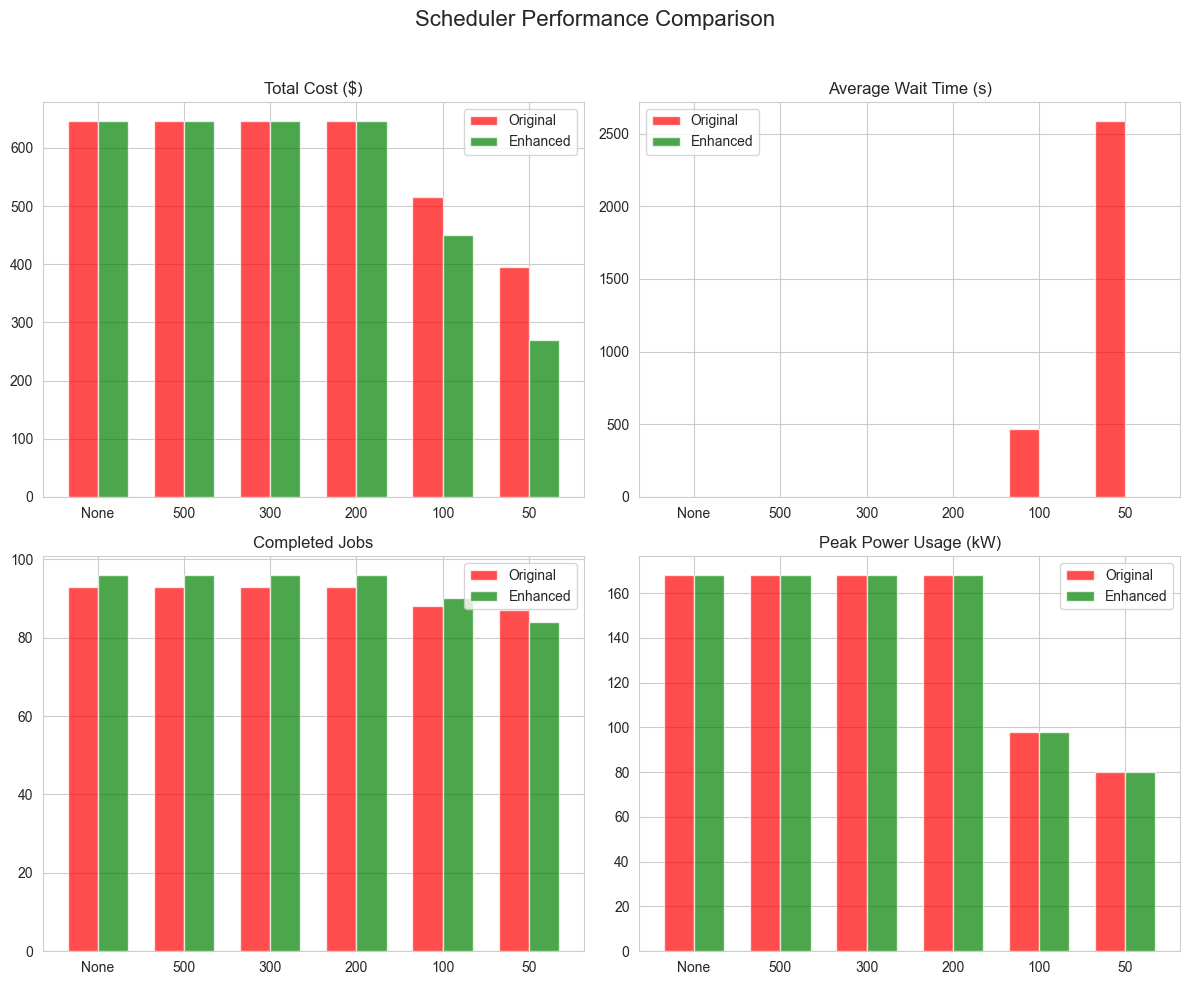

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_scheduler_results(results):
    """Visualize the comparison between the original and enhanced scheduler."""
    
    power_budgets = [r['power_budget'] if r['power_budget'] else 'None' for r in results]
    v1_costs = [r['v1_total_cost'] for r in results]
    v2_costs = [r['v2_total_cost'] for r in results]
    v1_waits = [r['v1_avg_wait'] for r in results]
    v2_waits = [r['v2_avg_wait'] for r in results]
    v1_completed = [r['v1_completed'] for r in results]
    v2_completed = [r['v2_completed'] for r in results]
    v1_peak_power = [r['v1_peak_power'] for r in results]
    v2_peak_power = [r['v2_peak_power'] for r in results]

    x = np.arange(len(power_budgets))  # X-axis positions
    width = 0.35  # Bar width

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Scheduler Performance Comparison", fontsize=16)

    # Total Cost Comparison
    axs[0, 0].bar(x - width/2, v1_costs, width, label='Original', color='red', alpha=0.7)
    axs[0, 0].bar(x + width/2, v2_costs, width, label='Enhanced', color='green', alpha=0.7)
    axs[0, 0].set_title("Total Cost ($)")
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(power_budgets)
    axs[0, 0].legend()

    # Average Wait Time Comparison
    axs[0, 1].bar(x - width/2, v1_waits, width, label='Original', color='red', alpha=0.7)
    axs[0, 1].bar(x + width/2, v2_waits, width, label='Enhanced', color='green', alpha=0.7)
    axs[0, 1].set_title("Average Wait Time (s)")
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(power_budgets)
    axs[0, 1].legend()

    # Completed Jobs Comparison
    axs[1, 0].bar(x - width/2, v1_completed, width, label='Original', color='red', alpha=0.7)
    axs[1, 0].bar(x + width/2, v2_completed, width, label='Enhanced', color='green', alpha=0.7)
    axs[1, 0].set_title("Completed Jobs")
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(power_budgets)
    axs[1, 0].legend()

    # Peak Power Usage Comparison
    axs[1, 1].bar(x - width/2, v1_peak_power, width, label='Original', color='red', alpha=0.7)
    axs[1, 1].bar(x + width/2, v2_peak_power, width, label='Enhanced', color='green', alpha=0.7)
    axs[1, 1].set_title("Peak Power Usage (kW)")
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(power_budgets)
    axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Call visualization function with results
visualize_scheduler_results(results)


In [65]:
import pandas as pd
from datetime import datetime, timedelta
# from power_aware_scheduler import PowerAwareScheduler
# from enhanced_scheduler import EnhancedPowerAwareScheduler

def prepare_test_data(df, start_date, num_days=1):
    """
    Prepare a subset of data for testing
    """
    # Convert submit_time to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['submit_time']):
        df['submit_time'] = pd.to_datetime(df['submit_time'])
    
    # Filter data for the specified date range
    end_date = start_date + timedelta(days=num_days)
    test_df = df[
        (df['submit_time'] >= start_date) & 
        (df['submit_time'] < end_date)
    ].copy()
    
    print(f"\nTest Data Statistics:")
    print(f"Date Range: {start_date.date()} to {end_date.date()}")
    print(f"Number of jobs: {len(test_df)}")
    
    return test_df

def compare_scheduler_versions(df, power_budgets, start_date=None, num_days=1):
    """
    Compare original and enhanced scheduler versions with detailed metrics
    """
    # Prepare test data
    if start_date is None:
        start_date = df['submit_time'].min()
    
    test_df = prepare_test_data(df, start_date, num_days)
    results = []
    
    for budget in power_budgets:
        print(f"\nTesting with power budget: {budget if budget else 'None'} kW")
        
        # Run both versions
        scheduler_v1 = PowerAwareScheduler(peak_power_budget=budget)
        scheduler_v2 = EnhancedPowerAwareScheduler(peak_power_budget=budget)
        
        metrics_v1, summary_v1 = scheduler_v1.simulate(test_df)
        metrics_v2, summary_v2 = scheduler_v2.simulate(test_df)
        
        # Detailed comparisons
        comparison = {
            'power_budget': budget,
            'v1_total_cost': summary_v1['total_cost'],
            'v2_total_cost': summary_v2['total_cost'],
            'v1_avg_wait': summary_v1['wait_stats']['overall']['avg'],
            'v2_avg_wait': summary_v2['wait_stats']['overall']['avg'],
            'v1_completed': summary_v1['total_jobs'],
            'v2_completed': summary_v2['total_jobs'],
            'v1_peak_power': summary_v1['peak_max_power'],
            'v2_peak_power': summary_v2['peak_max_power'],
            'v1_peak_jobs': summary_v1['peak_jobs'],
            'v2_peak_jobs': summary_v2['peak_jobs'],
            'v1_offpeak_jobs': summary_v1['offpeak_jobs'],
            'v2_offpeak_jobs': summary_v2['offpeak_jobs']
        }
        
        # Calculate improvements
        comparison['cost_improvement'] = (
            (comparison['v1_total_cost'] - comparison['v2_total_cost']) 
            / comparison['v1_total_cost'] * 100
        )
        comparison['wait_improvement'] = (
            (comparison['v1_avg_wait'] - comparison['v2_avg_wait']) 
            / (comparison['v1_avg_wait'] if comparison['v1_avg_wait'] > 0 else 1) * 100
        )
        
        results.append(comparison)
        
        # Print detailed comparison
        print("\nComparison Results:")
        print(f"Total Cost: ${comparison['v1_total_cost']:.2f} -> ${comparison['v2_total_cost']:.2f} "
              f"({comparison['cost_improvement']:.1f}% improvement)")
        print(f"Average Wait Time: {comparison['v1_avg_wait']:.2f}s -> {comparison['v2_avg_wait']:.2f}s "
              f"({comparison['wait_improvement']:.1f}% improvement)")
        print(f"Completed Jobs: {comparison['v1_completed']} -> {comparison['v2_completed']}")
        print(f"Peak Power: {comparison['v1_peak_power']:.2f}kW -> {comparison['v2_peak_power']:.2f}kW")
        print(f"Peak/Off-peak Distribution:")
        print(f"  V1: {comparison['v1_peak_jobs']}/{comparison['v1_offpeak_jobs']} jobs")
        print(f"  V2: {comparison['v2_peak_jobs']}/{comparison['v2_offpeak_jobs']} jobs")
    
    return results

def main():
    # Read dataset
    df = pd.read_csv('synthetic_hpc_jobs_2020.csv')
    df['submit_time'] = pd.to_datetime(df['submit_time'])
    
    print("Full Dataset Statistics:")
    print(f"Date Range: {df['submit_time'].min()} to {df['submit_time'].max()}")
    print(f"Total Jobs: {len(df)}")
    
    # Test different date ranges
    test_dates = [
        (df['submit_time'].min(), 1),  # First day
        (df['submit_time'].min(), 7),  # First week
        (df['submit_time'].min() + timedelta(days=30), 1)  # A day after first month
    ]
    
    power_budgets = [None, 500, 300, 200, 100, 50]
    
    for start_date, num_days in test_dates:
        print(f"\n{'-'*50}")
        print(f"Testing period: {num_days} days starting {start_date.date()}")
        results = compare_scheduler_versions(df, power_budgets, start_date, num_days)

if __name__ == "__main__":
    main()

Full Dataset Statistics:
Date Range: 2020-05-01 00:09:21.667106 to 2020-10-01 00:45:27.090297
Total Jobs: 20980

--------------------------------------------------
Testing period: 1 days starting 2020-05-01

Test Data Statistics:
Date Range: 2020-05-01 to 2020-05-02
Number of jobs: 156

Testing with power budget: None kW

Comparison Results:
Total Cost: $1741.55 -> $1741.55 (0.0% improvement)
Average Wait Time: 0.00s -> 0.00s (0.0% improvement)
Completed Jobs: 154 -> 156
Peak Power: 682.79kW -> 682.79kW
Peak/Off-peak Distribution:
  V1: 139/15 jobs
  V2: 139/17 jobs

Testing with power budget: 500 kW

Comparison Results:
Total Cost: $1628.72 -> $1572.30 (3.5% improvement)
Average Wait Time: 151.62s -> 0.00s (100.0% improvement)
Completed Jobs: 151 -> 152
Peak Power: 499.67kW -> 499.67kW
Peak/Off-peak Distribution:
  V1: 135/16 jobs
  V2: 135/17 jobs

Testing with power budget: 300 kW

Comparison Results:
Total Cost: $1396.39 -> $1223.81 (12.4% improvement)
Average Wait Time: 1760.18s -

/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/3544689052.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power


Comparison Results:
Total Cost: $1628.72 -> $9124.73 (-460.2% improvement)
Average Wait Time: 152.63s -> 0.00s (100.0% improvement)
Completed Jobs: 150 -> 901
Peak Power: 499.67kW -> 499.67kW
Peak/Off-peak Distribution:
  V1: 135/15 jobs
  V2: 808/93 jobs

Testing with power budget: 300 kW

Comparison Results:
Total Cost: $1396.39 -> $6988.94 (-400.5% improvement)
Average Wait Time: 1760.18s -> 0.00s (100.0% improvement)
Completed Jobs: 143 -> 841
Peak Power: 299.59kW -> 299.70kW
Peak/Off-peak Distribution:
  V1: 122/21 jobs
  V2: 748/93 jobs

Testing with power budget: 200 kW


/tmp/ipykernel_6409/3544689052.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([



Comparison Results:
Total Cost: $1006.82 -> $5077.63 (-404.3% improvement)
Average Wait Time: 1378.56s -> 0.00s (100.0% improvement)
Completed Jobs: 132 -> 794
Peak Power: 199.63kW -> 199.98kW
Peak/Off-peak Distribution:
  V1: 114/18 jobs
  V2: 701/93 jobs

Testing with power budget: 100 kW


/tmp/ipykernel_6409/3544689052.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([



Comparison Results:
Total Cost: $656.63 -> $2700.19 (-311.2% improvement)
Average Wait Time: 6879.57s -> 0.00s (100.0% improvement)
Completed Jobs: 121 -> 710
Peak Power: 103.47kW -> 103.47kW
Peak/Off-peak Distribution:
  V1: 89/32 jobs
  V2: 617/93 jobs

Testing with power budget: 50 kW

Comparison Results:
Total Cost: $503.82 -> $1543.77 (-206.4% improvement)
Average Wait Time: 8487.64s -> 0.00s (100.0% improvement)
Completed Jobs: 110 -> 580
Peak Power: 103.47kW -> 103.47kW
Peak/Off-peak Distribution:
  V1: 72/38 jobs
  V2: 487/93 jobs

--------------------------------------------------
Testing period: 1 days starting 2020-05-31

Test Data Statistics:
Date Range: 2020-05-31 to 2020-06-01
Number of jobs: 35

Testing with power budget: None kW

Comparison Results:
Total Cost: $771.50 -> $771.50 (0.0% improvement)
Average Wait Time: 0.00s -> 0.00s (0.0% improvement)
Completed Jobs: 35 -> 35
Peak Power: 336.23kW -> 336.23kW
Peak/Off-peak Distribution:
  V1: 32/3 jobs
  V2: 32/3 jobs

T

/tmp/ipykernel_6409/3544689052.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/291943053.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_power = completed_jobs_df.groupby('power_category')['wait_time'].agg([
/tmp/ipykernel_6409/3544689052.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wait_by_powe

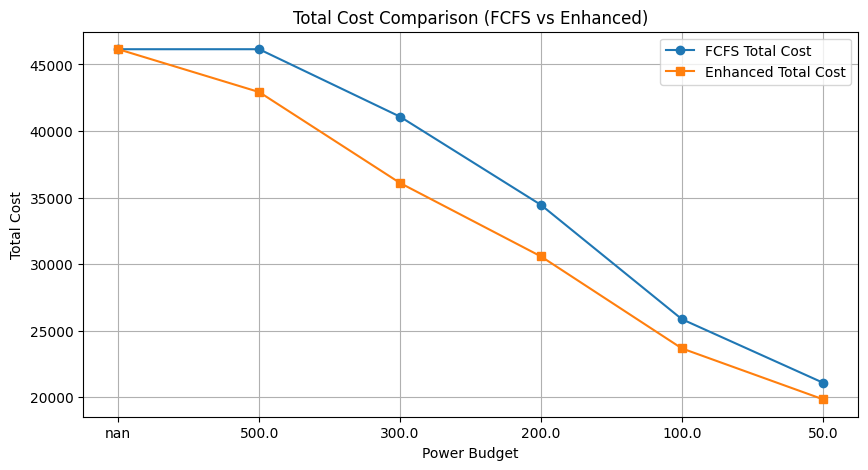

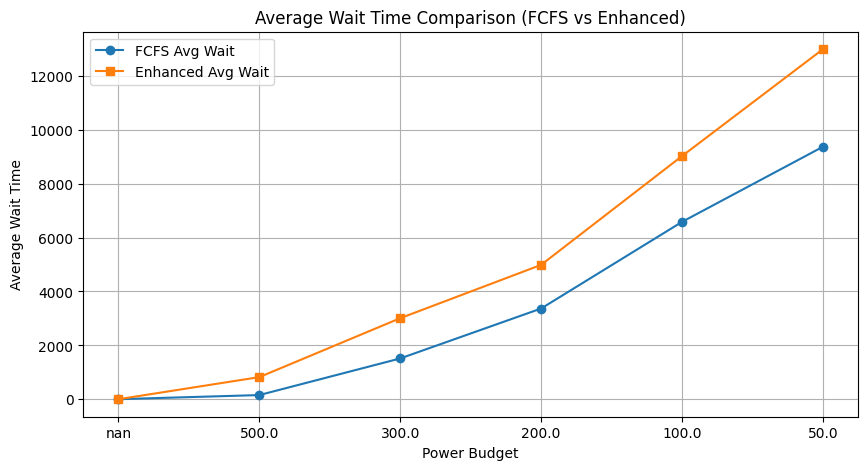

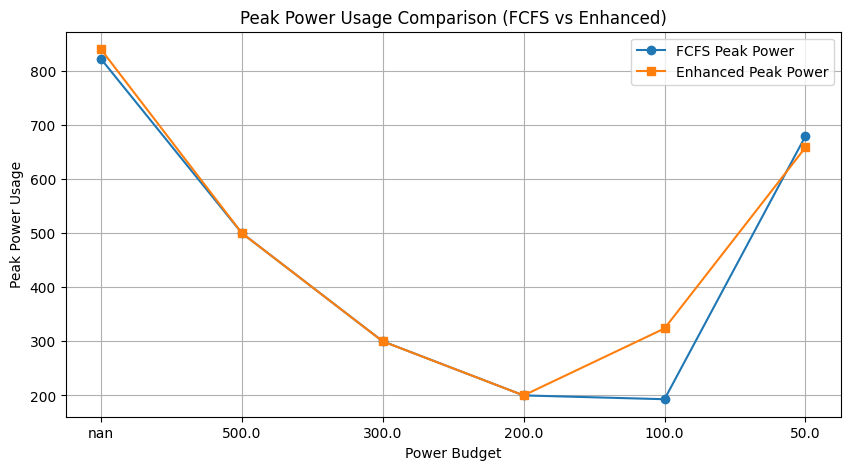

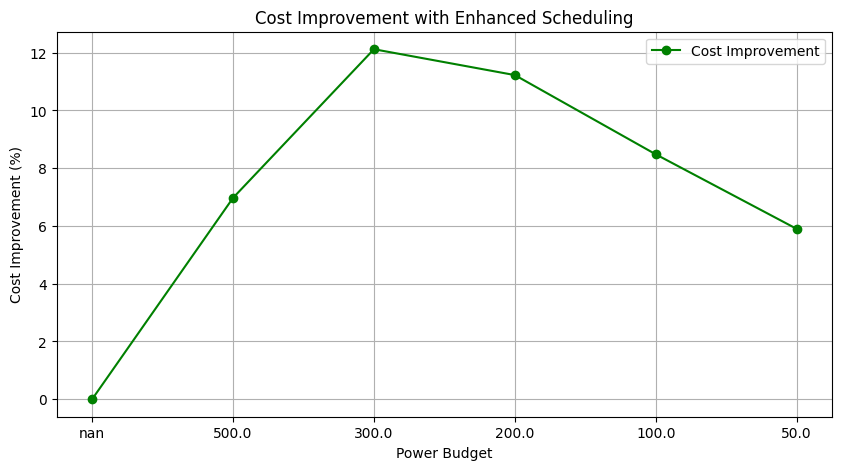

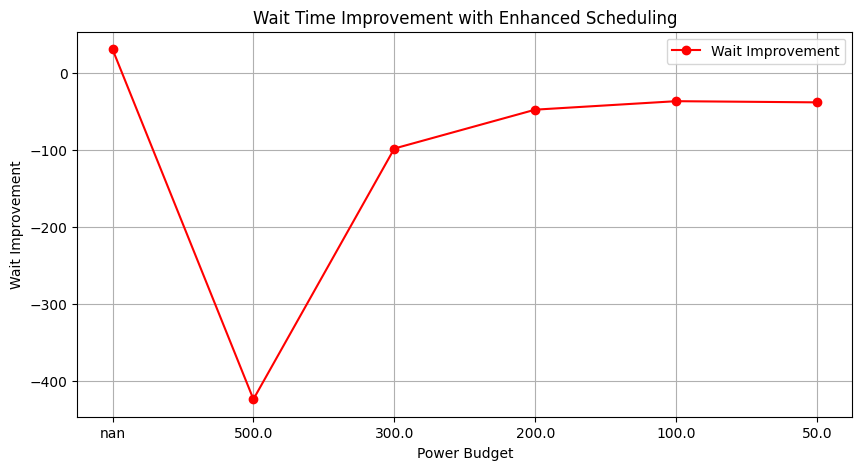

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
# data = {
#     "power_budget": [None, 500.0, 300.0, 200.0, 100.0, 50.0],
#     "fcfs_total_cost": [1741.560, 1741.560, 1641.207, 1328.482, 965.302, 785.386],
#     "enhanced_total_cost": [1741.560, 1628.725, 1396.401, 1082.791, 834.922, 731.749],
#     "fcfs_avg_wait": [0.000, 59.236, 1507.643, 3993.631, 7467.516, 10589.809],
#     "enhanced_avg_wait": [0.000, 597.115, 3587.720, 5549.767, 12800.926, 16682.849],
#     "fcfs_completed": [157, 157, 157, 157, 157, 157],
#     "enhanced_completed": [157, 157, 157, 157, 157, 157],
#     "fcfs_peak_power": [682.787, 498.413, 299.979, 199.967, 103.467, 103.467],
#     "enhanced_peak_power": [682.787, 499.669, 299.587, 199.626, 103.467, 103.467],
#     "cost_improvement": [0.000, 6.479, 14.916, 18.494, 13.507, 6.829],
#     "wait_improvement": [0.000, -908.032, -137.969, -38.965, -71.421, -57.537],
#     "fcfs_peak_cost": [1695.149, 1695.149, 1544.619, 1075.533, 530.762, 260.889],
#     "enhanced_peak_cost": [1695.149, 1525.896, 1177.410, 706.996, 335.193, 180.432],
#     "fcfs_offpeak_cost": [46.411, 46.411, 96.588, 252.950, 434.540, 524.498],
#     "enhanced_offpeak_cost": [46.411, 102.829, 218.991, 375.795, 499.730, 551.317]
# }

# 1 Month data
data = {
    "power_budget": [None, 500.0, 300.0, 200.0, 100.0, 50.0],
    "fcfs_total_cost": [46138.857, 46138.857, 41072.367, 34448.092, 25867.603, 21104.247],
    "enhanced_total_cost": [46138.857, 42921.476, 36093.460, 30581.009, 23673.451, 19859.074],
    "fcfs_avg_wait": [4.741, 157.259, 1516.074, 3367.926, 6582.667, 9370.074],
    "enhanced_avg_wait": [3.306, 823.067, 3008.949, 4987.102, 9024.288, 12988.253],
    "fcfs_completed": [4050, 4050, 4050, 4050, 4050, 4050],
    "enhanced_completed": [4050, 4050, 4050, 4050, 4050, 4050],
    "fcfs_peak_power": [821.905, 499.985, 299.996, 199.996, 192.959, 678.936],
    "enhanced_peak_power": [839.540, 499.985, 299.877, 199.982, 323.735, 658.057],
    "cost_improvement": [0.000, 6.973, 12.122, 11.226, 8.482, 5.900],
    "wait_improvement": [30.255, -423.382, -98.470, -48.076, -37.092, -38.614],
    "fcfs_peak_cost": [44557.671, 44557.671, 36957.936, 27021.523, 14150.790, 7005.755],
    "enhanced_peak_cost": [44557.671, 39731.600, 29489.576, 21220.899, 10859.562, 5137.996],
    "fcfs_offpeak_cost": [1581.186, 1581.186, 4114.431, 7426.569, 11716.813, 14098.491],
    "enhanced_offpeak_cost": [1581.186, 3189.877, 6603.885, 9360.110, 12813.889, 14721.078]
}


# Convert to DataFrame
df = pd.DataFrame(data)

# Convert power_budget to string for x-axis labeling
df["power_budget"] = df["power_budget"].astype(str)

# Plot Total Cost Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_total_cost"], marker='o', label="FCFS Total Cost")
plt.plot(df["power_budget"], df["enhanced_total_cost"], marker='s', label="Enhanced Total Cost")
plt.xlabel("Power Budget")
plt.ylabel("Total Cost")
plt.title("Total Cost Comparison (FCFS vs Enhanced)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Average Wait Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_avg_wait"], marker='o', label="FCFS Avg Wait")
plt.plot(df["power_budget"], df["enhanced_avg_wait"], marker='s', label="Enhanced Avg Wait")
plt.xlabel("Power Budget")
plt.ylabel("Average Wait Time")
plt.title("Average Wait Time Comparison (FCFS vs Enhanced)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Peak Power Usage Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_peak_power"], marker='o', label="FCFS Peak Power")
plt.plot(df["power_budget"], df["enhanced_peak_power"], marker='s', label="Enhanced Peak Power")
plt.xlabel("Power Budget")
plt.ylabel("Peak Power Usage")
plt.title("Peak Power Usage Comparison (FCFS vs Enhanced)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Cost Improvement
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["cost_improvement"], marker='o', color='green', label="Cost Improvement")
plt.xlabel("Power Budget")
plt.ylabel("Cost Improvement (%)")
plt.title("Cost Improvement with Enhanced Scheduling")
plt.legend()
plt.grid(True)
plt.show()

# Plot Wait Time Improvement
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["wait_improvement"], marker='o', color='red', label="Wait Improvement")
plt.xlabel("Power Budget")
plt.ylabel("Wait Improvement")
plt.title("Wait Time Improvement with Enhanced Scheduling")
plt.legend()
plt.grid(True)
plt.show()


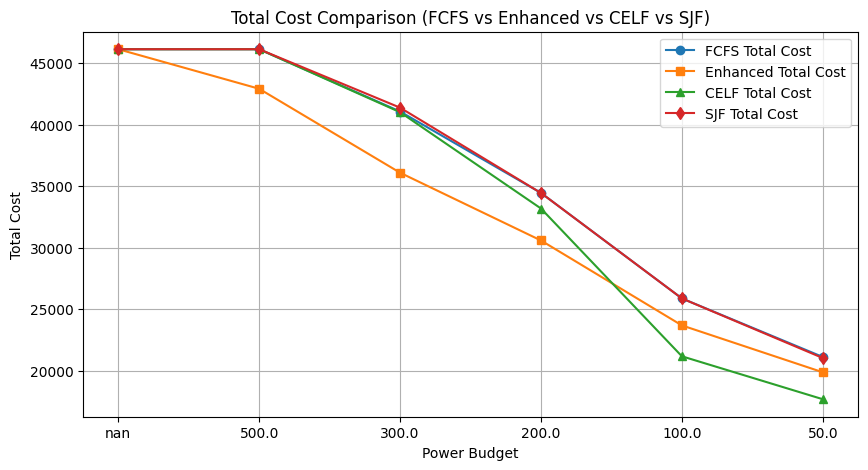

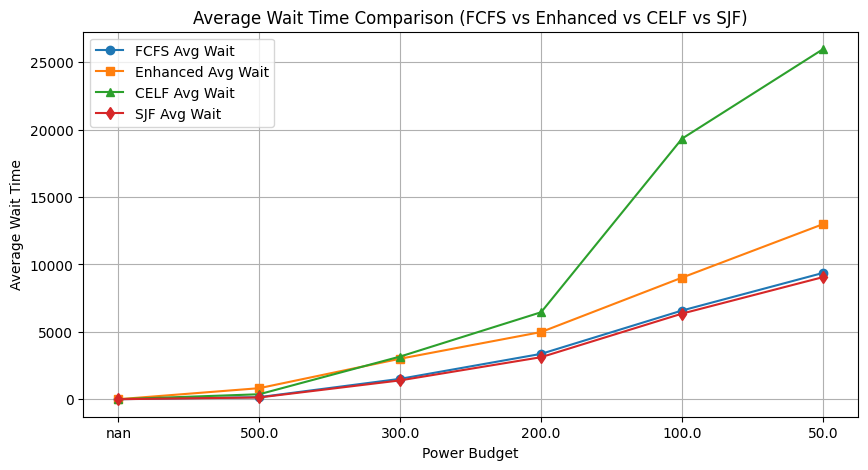

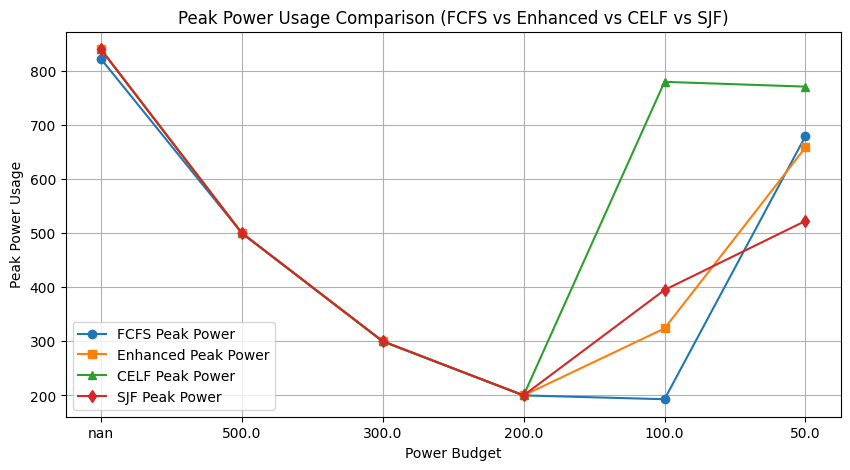

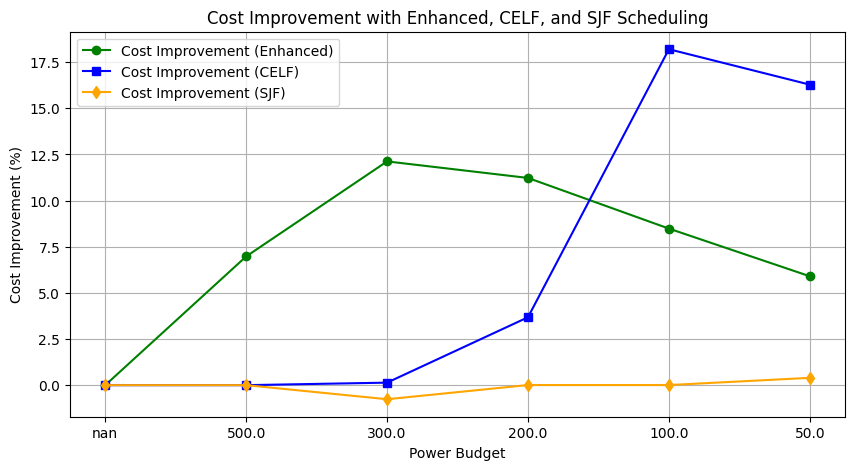

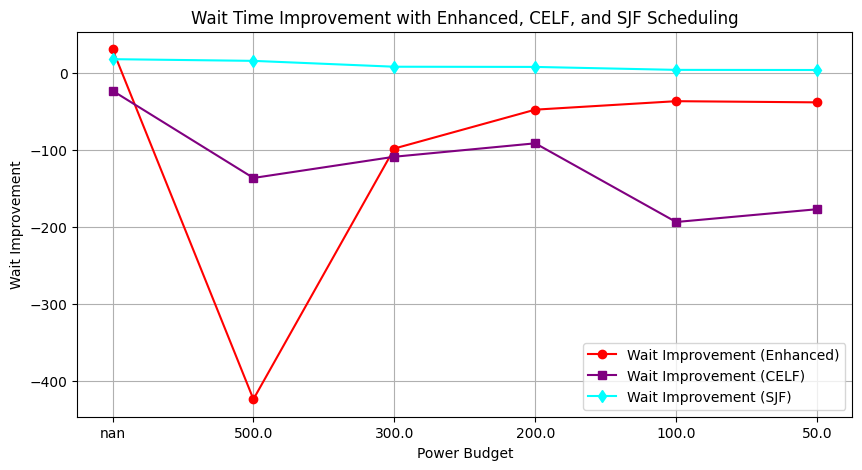

In [1]:
# Re-import necessary libraries after execution state reset
import pandas as pd
import matplotlib.pyplot as plt

# Re-create the dataset for visualization
data = {
    "power_budget": [None, 500.0, 300.0, 200.0, 100.0, 50.0],
    "fcfs_total_cost": [46138.857, 46138.857, 41072.367, 34448.092, 25867.603, 21104.247],
    "enhanced_total_cost": [46138.857, 42921.476, 36093.460, 30581.009, 23673.451, 19859.074],
    "celf_total_cost": [46138.857, 46138.857, 41016.433, 33180.839, 21159.778, 17668.211],
    "sjf_total_cost": [46138.857, 46138.857, 41385.421, 34445.927, 25866.430, 21020.648],
    "fcfs_avg_wait": [4.741, 157.259, 1516.074, 3367.926, 6582.667, 9370.074],
    "enhanced_avg_wait": [3.306, 823.067, 3008.949, 4987.102, 9024.288, 12988.253],
    "celf_avg_wait": [5.855, 372.088, 3170.060, 6456.211, 19332.760, 25966.955],
    "sjf_avg_wait": [3.917, 133.405, 1401.249, 3121.529, 6353.418, 9059.702],
    "fcfs_peak_power": [821.905, 499.985, 299.996, 199.996, 192.959, 678.936],
    "enhanced_peak_power": [839.540, 499.985, 299.877, 199.982, 323.735, 658.057],
    "celf_peak_power": [839.540, 499.991, 299.999, 199.996, 779.267, 770.451],
    "sjf_peak_power": [839.540, 499.992, 299.999, 199.998, 394.790, 522.277],
    "cost_improvement_enhanced": [0.000, 6.973, 12.122, 11.226, 8.482, 5.900],
    "wait_improvement_enhanced": [30.255, -423.382, -98.470, -48.076, -37.092, -38.614],
    "cost_improvement_celf": [0.000, -0.000, 0.136, 3.679, 18.200, 16.281],
    "wait_improvement_celf": [-23.510, -136.608, -109.097, -91.697, -193.692, -177.126],
    "cost_improvement_sjf": [0.000, 0.000, -0.762, 0.006, 0.005, 0.396],
    "wait_improvement_sjf": [17.371, 15.169, 7.574, 7.316, 3.483, 3.312],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert power_budget to string for x-axis labeling
df["power_budget"] = df["power_budget"].astype(str)

# Plot Total Cost Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_total_cost"], marker='o', label="FCFS Total Cost")
plt.plot(df["power_budget"], df["enhanced_total_cost"], marker='s', label="Enhanced Total Cost")
plt.plot(df["power_budget"], df["celf_total_cost"], marker='^', label="CELF Total Cost")
plt.plot(df["power_budget"], df["sjf_total_cost"], marker='d', label="SJF Total Cost")
plt.xlabel("Power Budget")
plt.ylabel("Total Cost")
plt.title("Total Cost Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Average Wait Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_avg_wait"], marker='o', label="FCFS Avg Wait")
plt.plot(df["power_budget"], df["enhanced_avg_wait"], marker='s', label="Enhanced Avg Wait")
plt.plot(df["power_budget"], df["celf_avg_wait"], marker='^', label="CELF Avg Wait")
plt.plot(df["power_budget"], df["sjf_avg_wait"], marker='d', label="SJF Avg Wait")
plt.xlabel("Power Budget")
plt.ylabel("Average Wait Time")
plt.title("Average Wait Time Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Peak Power Usage Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_peak_power"], marker='o', label="FCFS Peak Power")
plt.plot(df["power_budget"], df["enhanced_peak_power"], marker='s', label="Enhanced Peak Power")
plt.plot(df["power_budget"], df["celf_peak_power"], marker='^', label="CELF Peak Power")
plt.plot(df["power_budget"], df["sjf_peak_power"], marker='d', label="SJF Peak Power")
plt.xlabel("Power Budget")
plt.ylabel("Peak Power Usage")
plt.title("Peak Power Usage Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Cost Improvement Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["cost_improvement_enhanced"], marker='o', color='green', label="Cost Improvement (Enhanced)")
plt.plot(df["power_budget"], df["cost_improvement_celf"], marker='s', color='blue', label="Cost Improvement (CELF)")
plt.plot(df["power_budget"], df["cost_improvement_sjf"], marker='d', color='orange', label="Cost Improvement (SJF)")
plt.xlabel("Power Budget")
plt.ylabel("Cost Improvement (%)")
plt.title("Cost Improvement with Enhanced, CELF, and SJF Scheduling")
plt.legend()
plt.grid(True)
plt.show()

# Plot Wait Time Improvement Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["wait_improvement_enhanced"], marker='o', color='red', label="Wait Improvement (Enhanced)")
plt.plot(df["power_budget"], df["wait_improvement_celf"], marker='s', color='purple', label="Wait Improvement (CELF)")
plt.plot(df["power_budget"], df["wait_improvement_sjf"], marker='d', color='cyan', label="Wait Improvement (SJF)")
plt.xlabel("Power Budget")
plt.ylabel("Wait Improvement")
plt.title("Wait Time Improvement with Enhanced, CELF, and SJF Scheduling")
plt.legend()
plt.grid(True)
plt.show()


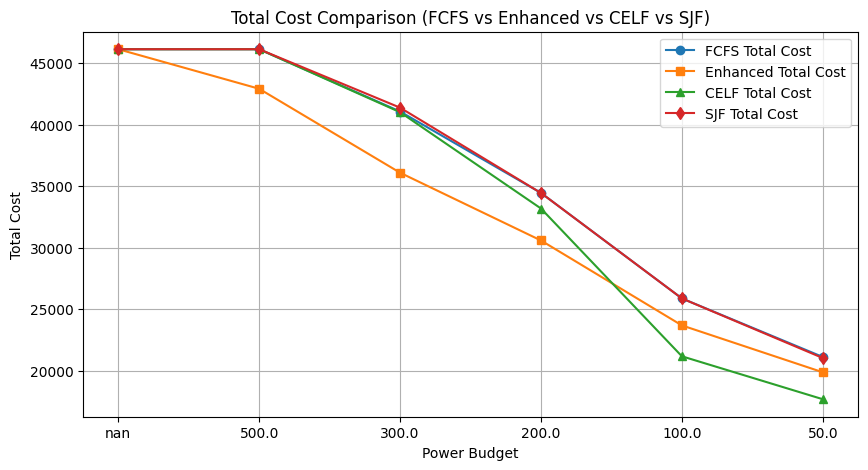

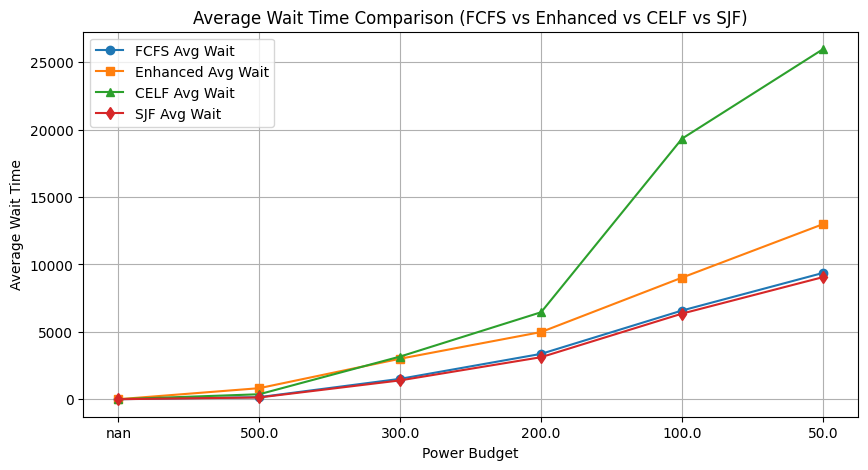

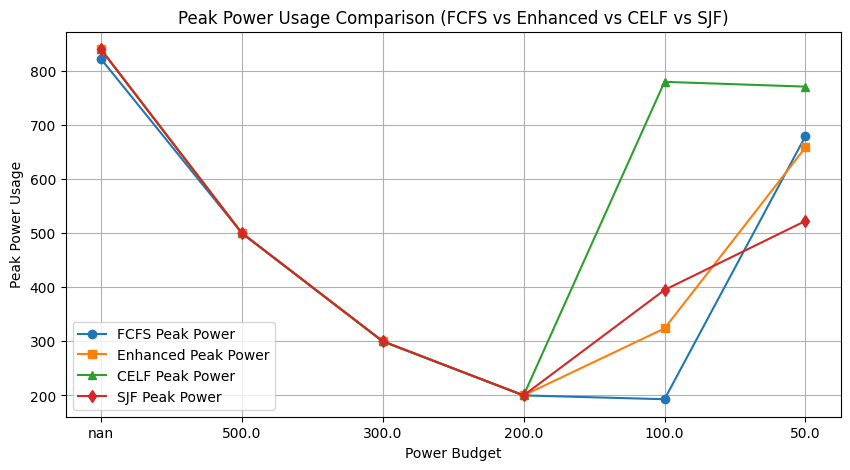

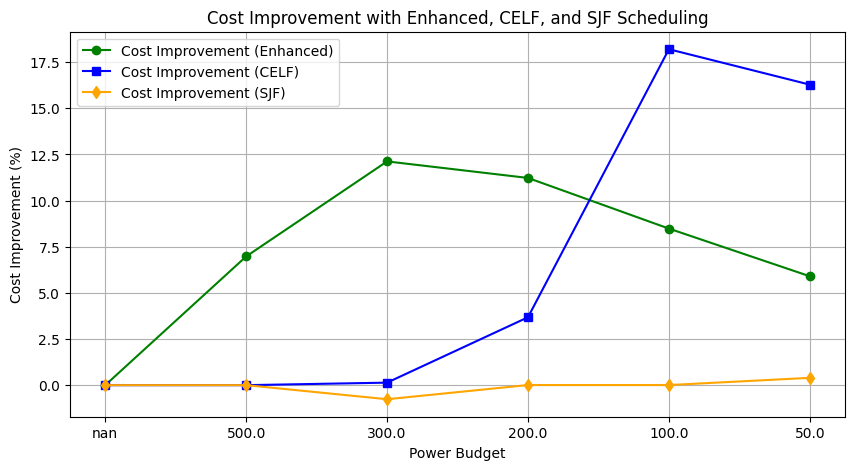

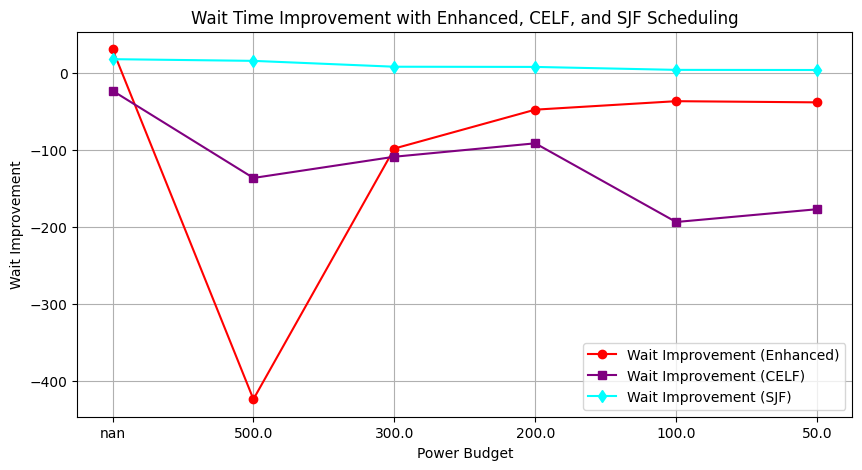

In [7]:
# Create the dataset for visualization
data = {
    "power_budget": [None, 500.0, 300.0, 200.0, 100.0, 50.0],
    "fcfs_total_cost": [46138.857, 46138.857, 41072.367, 34448.092, 25867.603, 21104.247],
    "enhanced_total_cost": [46138.857, 42921.476, 36093.460, 30581.009, 23673.451, 19859.074],
    "celf_total_cost": [46138.857, 46138.857, 41016.433, 33180.839, 21159.778, 17668.211],
    "sjf_total_cost": [46138.857, 46138.857, 41385.421, 34445.927, 25866.430, 21020.648],
    "fcfs_avg_wait": [4.741, 157.259, 1516.074, 3367.926, 6582.667, 9370.074],
    "enhanced_avg_wait": [3.306, 823.067, 3008.949, 4987.102, 9024.288, 12988.253],
    "celf_avg_wait": [5.855, 372.088, 3170.060, 6456.211, 19332.760, 25966.955],
    "sjf_avg_wait": [3.917, 133.405, 1401.249, 3121.529, 6353.418, 9059.702],
    "fcfs_peak_power": [821.905, 499.985, 299.996, 199.996, 192.959, 678.936],
    "enhanced_peak_power": [839.540, 499.985, 299.877, 199.982, 323.735, 658.057],
    "celf_peak_power": [839.540, 499.991, 299.999, 199.996, 779.267, 770.451],
    "sjf_peak_power": [839.540, 499.992, 299.999, 199.998, 394.790, 522.277],
    "cost_improvement_enhanced": [0.000, 6.973, 12.122, 11.226, 8.482, 5.900],
    "wait_improvement_enhanced": [30.255, -423.382, -98.470, -48.076, -37.092, -38.614],
    "cost_improvement_celf": [0.000, -0.000, 0.136, 3.679, 18.200, 16.281],
    "wait_improvement_celf": [-23.510, -136.608, -109.097, -91.697, -193.692, -177.126],
    "cost_improvement_sjf": [0.000, 0.000, -0.762, 0.006, 0.005, 0.396],
    "wait_improvement_sjf": [17.371, 15.169, 7.574, 7.316, 3.483, 3.312],
    "fcfs_peak_cost": [44557.671, 44557.671, 36957.936, 27021.523, 14150.790, 7005.755],
    "enhanced_peak_cost": [44557.671, 39731.600, 29489.576, 21220.899, 10859.562, 5137.996],
    "celf_peak_cost": [44557.671, 44557.671, 36874.035, 25120.644, 7089.053, 1851.702],
    "sjf_peak_cost": [44557.671, 44557.671, 37427.517, 27018.276, 14149.031, 6880.358],
    "fcfs_offpeak_cost": [1581.186, 1581.186, 4114.431, 7426.569, 11716.813, 14098.491],
    "enhanced_offpeak_cost": [1581.186, 3189.877, 6603.885, 9360.110, 12813.889, 14721.078],
    "celf_offpeak_cost": [1581.186, 1581.186, 4142.398, 8060.195, 14070.726, 15816.509],
    "sjf_offpeak_cost": [1581.186, 1581.186, 3957.904, 7427.651, 11717.400, 14140.290]
}


# Convert to DataFrame
df = pd.DataFrame(data)

# Convert power_budget to string for x-axis labeling
df["power_budget"] = df["power_budget"].astype(str)

# Plot Total Cost Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_total_cost"], marker='o', label="FCFS Total Cost")
plt.plot(df["power_budget"], df["enhanced_total_cost"], marker='s', label="Enhanced Total Cost")
plt.plot(df["power_budget"], df["celf_total_cost"], marker='^', label="CELF Total Cost")
plt.plot(df["power_budget"], df["sjf_total_cost"], marker='d', label="SJF Total Cost")
plt.xlabel("Power Budget")
plt.ylabel("Total Cost")
plt.title("Total Cost Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Average Wait Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_avg_wait"], marker='o', label="FCFS Avg Wait")
plt.plot(df["power_budget"], df["enhanced_avg_wait"], marker='s', label="Enhanced Avg Wait")
plt.plot(df["power_budget"], df["celf_avg_wait"], marker='^', label="CELF Avg Wait")
plt.plot(df["power_budget"], df["sjf_avg_wait"], marker='d', label="SJF Avg Wait")
plt.xlabel("Power Budget")
plt.ylabel("Average Wait Time")
plt.title("Average Wait Time Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Peak Power Usage Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_peak_power"], marker='o', label="FCFS Peak Power")
plt.plot(df["power_budget"], df["enhanced_peak_power"], marker='s', label="Enhanced Peak Power")
plt.plot(df["power_budget"], df["celf_peak_power"], marker='^', label="CELF Peak Power")
plt.plot(df["power_budget"], df["sjf_peak_power"], marker='d', label="SJF Peak Power")
plt.xlabel("Power Budget")
plt.ylabel("Peak Power Usage")
plt.title("Peak Power Usage Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Cost Improvement Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["cost_improvement_enhanced"], marker='o', color='green', label="Cost Improvement (Enhanced)")
plt.plot(df["power_budget"], df["cost_improvement_celf"], marker='s', color='blue', label="Cost Improvement (CELF)")
plt.plot(df["power_budget"], df["cost_improvement_sjf"], marker='d', color='orange', label="Cost Improvement (SJF)")
plt.xlabel("Power Budget")
plt.ylabel("Cost Improvement (%)")
plt.title("Cost Improvement with Enhanced, CELF, and SJF Scheduling")
plt.legend()
plt.grid(True)
plt.show()

# Plot Wait Time Improvement Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["wait_improvement_enhanced"], marker='o', color='red', label="Wait Improvement (Enhanced)")
plt.plot(df["power_budget"], df["wait_improvement_celf"], marker='s', color='purple', label="Wait Improvement (CELF)")
plt.plot(df["power_budget"], df["wait_improvement_sjf"], marker='d', color='cyan', label="Wait Improvement (SJF)")
plt.xlabel("Power Budget")
plt.ylabel("Wait Improvement")
plt.title("Wait Time Improvement with Enhanced, CELF, and SJF Scheduling")
plt.legend()
plt.grid(True)
plt.show()


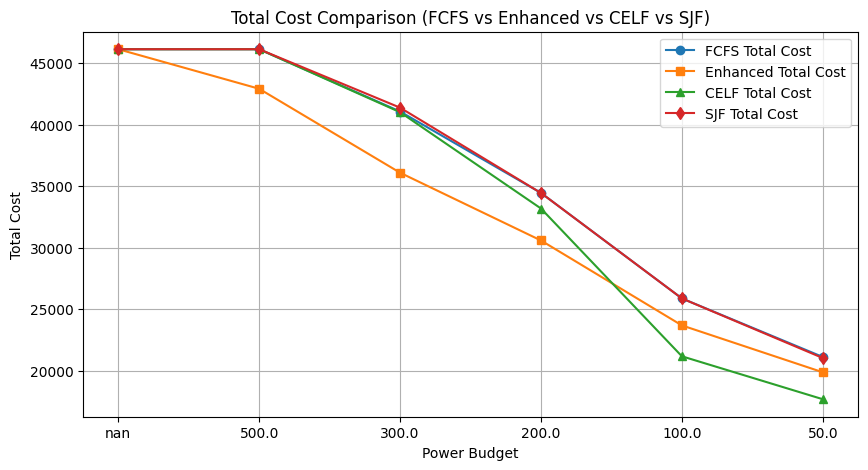

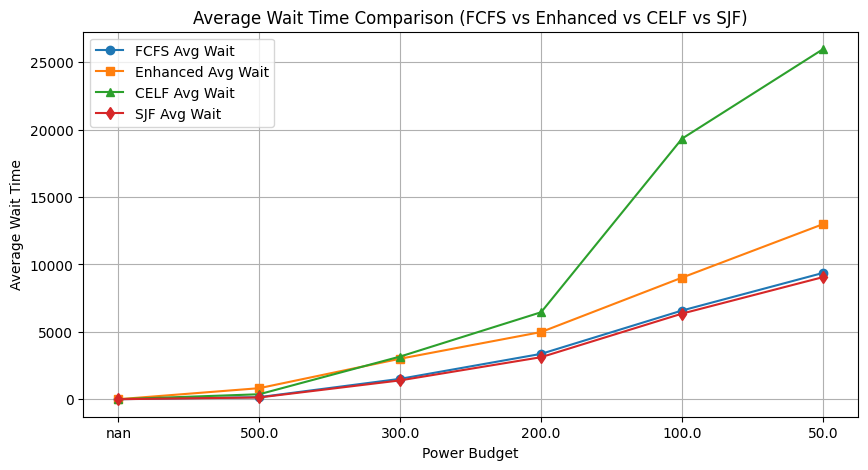

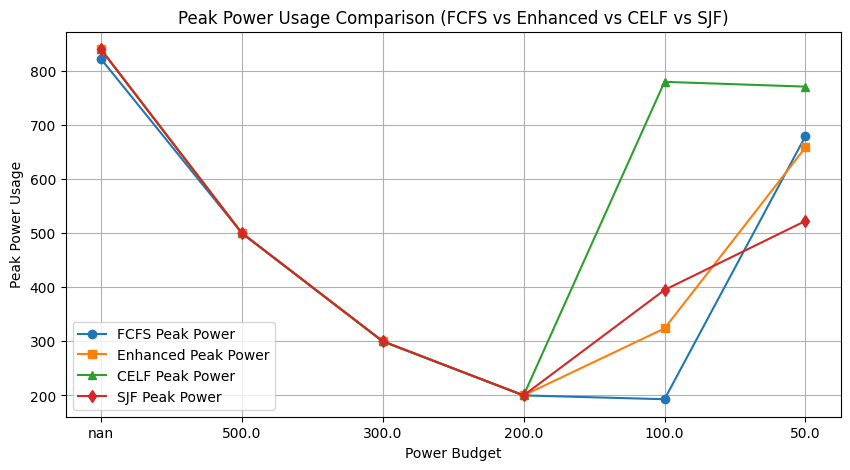

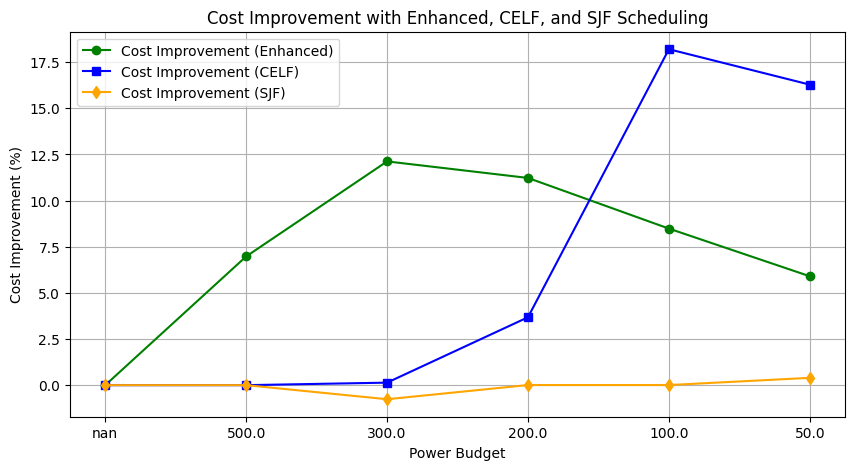

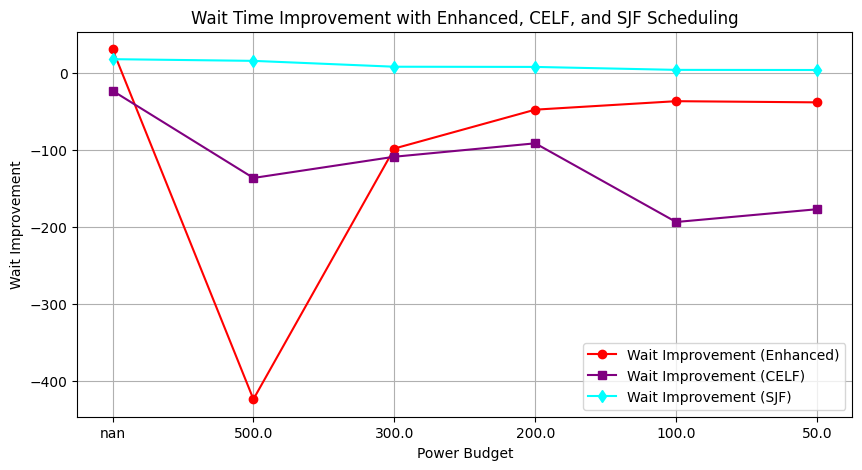

In [2]:
# Re-import necessary libraries after execution state reset
import pandas as pd
import matplotlib.pyplot as plt

# Re-create the dataset for visualization
data = {
    "power_budget": [None, 500.0, 300.0, 200.0, 100.0, 50.0],
    "fcfs_total_cost": [46138.857, 46138.857, 41072.367, 34448.092, 25867.603, 21104.247],
    "enhanced_total_cost": [46138.857, 42921.476, 36093.460, 30581.009, 23673.451, 19859.074],
    "celf_total_cost": [46138.857, 46138.857, 41016.433, 33180.839, 21159.778, 17668.211],
    "sjf_total_cost": [46138.857, 46138.857, 41385.421, 34445.927, 25866.430, 21020.648],
    "fcfs_avg_wait": [4.741, 157.259, 1516.074, 3367.926, 6582.667, 9370.074],
    "enhanced_avg_wait": [3.306, 823.067, 3008.949, 4987.102, 9024.288, 12988.253],
    "celf_avg_wait": [5.855, 372.088, 3170.060, 6456.211, 19332.760, 25966.955],
    "sjf_avg_wait": [3.917, 133.405, 1401.249, 3121.529, 6353.418, 9059.702],
    "fcfs_peak_power": [821.905, 499.985, 299.996, 199.996, 192.959, 678.936],
    "enhanced_peak_power": [839.540, 499.985, 299.877, 199.982, 323.735, 658.057],
    "celf_peak_power": [839.540, 499.991, 299.999, 199.996, 779.267, 770.451],
    "sjf_peak_power": [839.540, 499.992, 299.999, 199.998, 394.790, 522.277],
    "cost_improvement_enhanced": [0.000, 6.973, 12.122, 11.226, 8.482, 5.900],
    "wait_improvement_enhanced": [30.255, -423.382, -98.470, -48.076, -37.092, -38.614],
    "cost_improvement_celf": [0.000, -0.000, 0.136, 3.679, 18.200, 16.281],
    "wait_improvement_celf": [-23.510, -136.608, -109.097, -91.697, -193.692, -177.126],
    "cost_improvement_sjf": [0.000, 0.000, -0.762, 0.006, 0.005, 0.396],
    "wait_improvement_sjf": [17.371, 15.169, 7.574, 7.316, 3.483, 3.312],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert power_budget to string for x-axis labeling
df["power_budget"] = df["power_budget"].astype(str)

# Plot Total Cost Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_total_cost"], marker='o', label="FCFS Total Cost")
plt.plot(df["power_budget"], df["enhanced_total_cost"], marker='s', label="Enhanced Total Cost")
plt.plot(df["power_budget"], df["celf_total_cost"], marker='^', label="CELF Total Cost")
plt.plot(df["power_budget"], df["sjf_total_cost"], marker='d', label="SJF Total Cost")
plt.xlabel("Power Budget")
plt.ylabel("Total Cost")
plt.title("Total Cost Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Average Wait Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_avg_wait"], marker='o', label="FCFS Avg Wait")
plt.plot(df["power_budget"], df["enhanced_avg_wait"], marker='s', label="Enhanced Avg Wait")
plt.plot(df["power_budget"], df["celf_avg_wait"], marker='^', label="CELF Avg Wait")
plt.plot(df["power_budget"], df["sjf_avg_wait"], marker='d', label="SJF Avg Wait")
plt.xlabel("Power Budget")
plt.ylabel("Average Wait Time")
plt.title("Average Wait Time Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Peak Power Usage Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["fcfs_peak_power"], marker='o', label="FCFS Peak Power")
plt.plot(df["power_budget"], df["enhanced_peak_power"], marker='s', label="Enhanced Peak Power")
plt.plot(df["power_budget"], df["celf_peak_power"], marker='^', label="CELF Peak Power")
plt.plot(df["power_budget"], df["sjf_peak_power"], marker='d', label="SJF Peak Power")
plt.xlabel("Power Budget")
plt.ylabel("Peak Power Usage")
plt.title("Peak Power Usage Comparison (FCFS vs Enhanced vs CELF vs SJF)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Cost Improvement Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["cost_improvement_enhanced"], marker='o', color='green', label="Cost Improvement (Enhanced)")
plt.plot(df["power_budget"], df["cost_improvement_celf"], marker='s', color='blue', label="Cost Improvement (CELF)")
plt.plot(df["power_budget"], df["cost_improvement_sjf"], marker='d', color='orange', label="Cost Improvement (SJF)")
plt.xlabel("Power Budget")
plt.ylabel("Cost Improvement (%)")
plt.title("Cost Improvement with Enhanced, CELF, and SJF Scheduling")
plt.legend()
plt.grid(True)
plt.show()

# Plot Wait Time Improvement Comparison
plt.figure(figsize=(10, 5))
plt.plot(df["power_budget"], df["wait_improvement_enhanced"], marker='o', color='red', label="Wait Improvement (Enhanced)")
plt.plot(df["power_budget"], df["wait_improvement_celf"], marker='s', color='purple', label="Wait Improvement (CELF)")
plt.plot(df["power_budget"], df["wait_improvement_sjf"], marker='d', color='cyan', label="Wait Improvement (SJF)")
plt.xlabel("Power Budget")
plt.ylabel("Wait Improvement")
plt.title("Wait Time Improvement with Enhanced, CELF, and SJF Scheduling")
plt.legend()
plt.grid(True)
plt.show()
